# 2 - Predicción de demanda de electricidad

El problema consiste en predecir la demanda de electricidad.


In [127]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import json
from pathlib import Path
import pickle

ROWS_PER_DAY = 48 # Not true in all years but mostly true.


## Importar datos

In [2]:
data_df = pd.read_csv("data/historic_demand_2009_2023_noNaN.csv")

def convert_datetimes(df: pd.DataFrame):
    df = df.copy()
    df['settlement_date'] = pd.to_datetime(df['settlement_date'])
    df['period_hour'] = pd.to_datetime(df['period_hour'])
    return df

data_df = convert_datetimes(data_df)

print(data_df.dtypes)
display(data_df.head())
display(data_df.describe())

settlement_date              datetime64[ns]
settlement_period                     int64
period_hour                  datetime64[ns]
nd                                    int64
tsd                                   int64
england_wales_demand                  int64
embedded_wind_generation              int64
embedded_wind_capacity                int64
embedded_solar_generation             int64
embedded_solar_capacity               int64
non_bm_stor                           int64
pump_storage_pumping                  int64
ifa_flow                              int64
ifa2_flow                             int64
britned_flow                          int64
moyle_flow                            int64
east_west_flow                        int64
nemo_flow                             int64
is_holiday                            int64
dtype: object


/tmp/ipykernel_1665/368296741.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['period_hour'] = pd.to_datetime(df['period_hour'])


settlement_date  settlement_period         period_hour     nd    tsd  \
0 2009-01-01 00:00:00                  1 2023-07-28 00:00:00  37910  38704   
1 2009-01-01 00:30:00                  2 2023-07-28 00:30:00  38047  38964   
2 2009-01-01 01:00:00                  3 2023-07-28 01:00:00  37380  38651   
3 2009-01-01 01:30:00                  4 2023-07-28 01:30:00  36426  37775   
4 2009-01-01 02:00:00                  5 2023-07-28 02:00:00  35687  37298   

   england_wales_demand  embedded_wind_generation  embedded_wind_capacity  \
0                 33939                        54                    1403   
1                 34072                        53                    1403   
2                 33615                        53                    1403   
3                 32526                        50                    1403   
4                 31877                        50                    1403   

   embedded_solar_generation  embedded_solar_capacity  non_bm_stor  \
0                          0                        0            0   
1                          0                        0            0   
2                          0                        0            0   
3                          0                        0            0   
4                          0                        0            0   

   pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  moyle_flow  \
0                    33      2002          0             0        -161   
1                   157      2002          0             0        -160   
2                   511      2002          0             0        -160   
3                   589      1772          0             0        -160   
4                   851      1753          0             0        -160   

   east_west_flow  nemo_flow  is_holiday  
0               0          0           1  
1               0          0           1  
2               0          0           1  
3               0          0           1  
4               0          0           1

settlement_date  settlement_period  \
count                         250194      250194.000000   
mean   2016-03-03 19:21:46.801122560          24.497242   
min              2009-01-01 00:00:00           1.000000   
25%              2012-08-10 06:07:30          12.000000   
50%              2016-03-06 11:15:00          24.000000   
75%              2019-09-30 17:22:30          36.000000   
max              2023-04-25 23:30:00          48.000000   
std                              NaN          13.851967   

                         period_hour             nd            tsd  \
count                         250194  250194.000000  250194.000000   
mean   2023-07-28 11:44:55.035852032   31830.252924   33281.000795   
min              2023-07-28 00:00:00   13367.000000   16629.000000   
25%              2023-07-28 05:30:00   25620.000000   27268.000000   
50%              2023-07-28 11:30:00   31264.000000   32484.000000   
75%              2023-07-28 17:30:00   37540.000000   38704.000000   
max              2023-07-28 23:30:00   59095.000000   60147.000000   
std                              NaN    7772.990497    7568.625622   

       england_wales_demand  embedded_wind_generation  embedded_wind_capacity  \
count         250194.000000             250194.000000           250194.000000   
mean           28955.719937               1214.111070             4216.416317   
min                0.000000                  0.000000             1403.000000   
25%            23298.000000                522.000000             2085.000000   
50%            28421.000000                973.000000             4163.000000   
75%            34176.000000               1651.000000             6192.000000   
max            53325.000000               5354.000000             6574.000000   
std             7046.881689                926.112486             1924.315223   

       embedded_solar_generation  embedded_solar_capacity    non_bm_stor  \
count              250194.000000            250194.000000  250194.000000   
mean                  798.006271              7775.123264       7.423176   
min                     0.000000                 0.000000     -24.000000   
25%                     0.000000              1829.000000       0.000000   
50%                     0.000000              9300.000000       0.000000   
75%                   736.000000             13080.000000       0.000000   
max                  9830.000000             13861.000000     893.000000   
std                  1596.145771              5480.305258      41.288693   

       pump_storage_pumping       ifa_flow      ifa2_flow   britned_flow  \
count         250194.000000  250194.000000  250194.000000  250194.000000   
mean             320.470307     919.002234      11.460115     542.995539   
min                0.000000   -2056.000000   -1030.000000   -1215.000000   
25%                8.000000     206.000000       0.000000       0.000000   
50%               12.000000    1247.000000       0.000000     767.000000   
75%              465.000000    1899.000000       0.000000     994.000000   
max             2019.000000    2066.000000    1016.000000    1143.000000   
std              544.056120    1093.595345     308.067249     507.545181   

          moyle_flow  east_west_flow      nemo_flow     is_holiday  
count  250194.000000   250194.000000  250194.000000  250194.000000  
mean     -107.266953      -25.317638     151.336183       0.022638  
min      -505.000000     -585.000000   -1022.000000       0.000000  
25%      -251.000000     -128.000000       0.000000       0.000000  
50%      -119.000000        0.000000       0.000000       0.000000  
75%        46.000000        7.000000       0.000000       0.000000  
max       499.000000      504.000000    1033.000000       1.000000  
std       223.066403      251.334752     388.191533       0.148748

## División en entrenamiento, validación y pruebas

- Entrenamiento: 2009 hasta 2021.
- Validación: 2022
- Prueba: 2023

In [3]:
train_df, validation_df, test_df = data_df[data_df['settlement_date'].dt.year < 2022], data_df[data_df['settlement_date'].dt.year == 2022], data_df[data_df['settlement_date'].dt.year >= 2023]
train_label_df, validation_label_df, test_label_df = train_df["tsd"], validation_df["tsd"], test_df["tsd"]

print(train_df.size)
print(validation_df.size)
print(test_df.size)

display(train_df.tail())
display(validation_df)
display(test_df)

4316002
332842
104842


settlement_date  settlement_period         period_hour     nd  \
227153 2021-12-31 21:30:00                 44 2023-07-28 21:30:00  25718   
227154 2021-12-31 22:00:00                 45 2023-07-28 22:00:00  24571   
227155 2021-12-31 22:30:00                 46 2023-07-28 22:30:00  23743   
227156 2021-12-31 23:00:00                 47 2023-07-28 23:00:00  22821   
227157 2021-12-31 23:30:00                 48 2023-07-28 23:30:00  22342   

          tsd  england_wales_demand  embedded_wind_generation  \
227153  26611                 23602                      2005   
227154  25852                 22621                      2056   
227155  25039                 21850                      2107   
227156  23661                 21026                      2189   
227157  23761                 20678                      2270   

        embedded_wind_capacity  embedded_solar_generation  \
227153                    6527                          0   
227154                    6527                          0   
227155                    6527                          0   
227156                    6527                          0   
227157                    6527                          0   

        embedded_solar_capacity  non_bm_stor  pump_storage_pumping  ifa_flow  \
227153                    13080            0                    17      -272   
227154                    13080            0                    19      -658   
227155                    13080            0                    22      -670   
227156                    13080            0                    24      -212   
227157                    13080            0                   623      -192   

        ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
227153         -4          1052         321             504        853   
227154         -4          1043         321             504        658   
227155         -4          1016         321             504        642   
227156         -4           624         298             437         31   
227157         -4           624         284             305          0   

        is_holiday  
227153           0  
227154           0  
227155           0  
227156           0  
227157           0

settlement_date  settlement_period         period_hour     nd  \
227158 2022-01-01 00:00:00                  1 2023-07-28 00:00:00  21940   
227159 2022-01-01 00:30:00                  2 2023-07-28 00:30:00  22427   
227160 2022-01-01 01:00:00                  3 2023-07-28 01:00:00  21896   
227161 2022-01-01 01:30:00                  4 2023-07-28 01:30:00  20693   
227162 2022-01-01 02:00:00                  5 2023-07-28 02:00:00  19481   
...                    ...                ...                 ...    ...   
244671 2022-12-31 21:30:00                 44 2023-07-28 21:30:00  24160   
244672 2022-12-31 22:00:00                 45 2023-07-28 22:00:00  23223   
244673 2022-12-31 22:30:00                 46 2023-07-28 22:30:00  22627   
244674 2022-12-31 23:00:00                 47 2023-07-28 23:00:00  21690   
244675 2022-12-31 23:30:00                 48 2023-07-28 23:30:00  21229   

          tsd  england_wales_demand  embedded_wind_generation  \
227158  23275                 20513                      2412   
227159  23489                 21021                      2554   
227160  23672                 20619                      2696   
227161  23272                 19615                      2838   
227162  23958                 18545                      2977   
...       ...                   ...                       ...   
244671  25634                 21879                      2592   
244672  24788                 21040                      2701   
244673  24365                 20466                      2810   
244674  24766                 19587                      2823   
244675  24843                 19157                      2836   

        embedded_wind_capacity  embedded_solar_generation  \
227158                    6527                          0   
227159                    6527                          0   
227160                    6527                          0   
227161                    6527                          0   
227162                    6527                          0   
...                        ...                        ...   
244671                    6545                          0   
244672                    6545                          0   
244673                    6545                          0   
244674                    6545                          0   
244675                    6545                          0   

        embedded_solar_capacity  non_bm_stor  pump_storage_pumping  ifa_flow  \
227158                    13670            0                   450      -181   
227159                    13670            0                   173      -181   
227160                    13670            0                   799      -164   
227161                    13670            0                  1516      -170   
227162                    13670            0                  1490      -753   
...                         ...          ...                   ...       ...   
244671                    13861            0                   184      1004   
244672                    13861            0                   124       244   
244673                    13861            0                   173       114   
244674                    13861            0                   819       682   
244675                    13861            0                  1154       756   

        ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
227158         -4           586         320             384       -100   
227159         -4           583         320             403       -104   
227160         -4           567         320             440         -4   
227161         -4           444         320             387         -6   
227162         -4          -383         320             476       -561   
...           ...           ...         ...             ...        ...   
244671        982          1002        -451            -239        999   
244672        353           473

settlement_date  settlement_period         period_hour     nd  \
244676 2023-01-01 00:00:00                  1 2023-07-28 00:00:00  21043   
244677 2023-01-01 00:30:00                  2 2023-07-28 00:30:00  21756   
244678 2023-01-01 01:00:00                  3 2023-07-28 01:00:00  21348   
244679 2023-01-01 01:30:00                  4 2023-07-28 01:30:00  20586   
244680 2023-01-01 02:00:00                  5 2023-07-28 02:00:00  19781   
...                    ...                ...                 ...    ...   
250189 2023-04-25 21:30:00                 44 2023-07-28 21:30:00  30635   
250190 2023-04-25 22:00:00                 45 2023-07-28 22:00:00  28784   
250191 2023-04-25 22:30:00                 46 2023-07-28 22:30:00  27302   
250192 2023-04-25 23:00:00                 47 2023-07-28 23:00:00  25457   
250193 2023-04-25 23:30:00                 48 2023-07-28 23:30:00  24371   

          tsd  england_wales_demand  embedded_wind_generation  \
244676  24680                 18995                      2815   
244677  25289                 19730                      2793   
244678  25269                 19327                      2773   
244679  24574                 18589                      2753   
244680  24135                 17806                      2712   
...       ...                   ...                       ...   
250189  31142                 27695                       490   
250190  29292                 26071                       489   
250191  27807                 24719                       487   
250192  26244                 23014                       492   
250193  25407                 21983                       497   

        embedded_wind_capacity  embedded_solar_generation  \
244676                    6545                          0   
244677                    6545                          0   
244678                    6545                          0   
244679                    6545                          0   
244680                    6545                          0   
...                        ...                        ...   
250189                    6545                          0   
250190                    6545                          0   
250191                    6545                          0   
250192                    6545                          0   
250193                    6545                          0   

        embedded_solar_capacity  non_bm_stor  pump_storage_pumping  ifa_flow  \
244676                    13080            0                  1161       609   
244677                    13080            0                  1056       596   
244678                    13080            0                  1212       516   
244679                    13080            0                  1237       510   
244680                    13080            0                  1233       600   
...                         ...          ...                   ...       ...   
250189                    13080            0                     7      1671   
250190                    13080            0                     8      1123   
250191                    13080            0                     5      1075   
250192                    13080            0                     5       483   
250193                    13080            0                    10       436   

        ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
244676        903          -896        -451            -529        253   
244677        904          -897        -451            -529        252   
244678        983          -910        -451            -529        253   
244679        989          -911        -413            -529        254   
244680        903          -912        -401            -529        253   
...           ...           ...         ...             ...        ...   
250189        888          1047          69               0        232   
250190        286           883

In [4]:
from typing import Literal
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def clean_df(df: pd.DataFrame):
    df = df.drop(["settlement_period", "settlement_date", "period_hour"])

def get_standard_scaler(df: pd.DataFrame, to_scale: list):
    df = df.copy()
    std_scaler = StandardScaler()
    scaled_df = df[to_scale]
    std_scaler.fit(scaled_df)
    df[to_scale] = std_scaler.transform(scaled_df)
    return df, std_scaler

def plot_day_data(data: pd.DataFrame, initial_day: int, end_day: int, tag: str, ax = None):
    data[initial_day * ROWS_PER_DAY : end_day * ROWS_PER_DAY].plot(title=f"{tag} Day {initial_day} to day {end_day}", ax = ax)
    plt.show()


## Visualización de datos

- A partir del 2013 los datos no contienen anomalias en el conteo de mediciones anuales.
- Se encuentran patrones a nivel de:
  - Día: En dependencia del momento del año la demanda tiene uno o dos picos y mesetas.
  - Semana: Los fines de semana el consumo es menor que en el resto de la semana.
  - Feriado: 1ro de enero feriado - Contiene un consumo similar a fin de semana.
  - Mensual: Los meses se mantienen de forma similar repitiendo el patrón semanal.
  - Anual: El consumo es mayor al inicio del año, decrece a mediados y nuevamente aumenta a finales de año.
  - General: La demanda tiene a disminuir con al paso de los años.

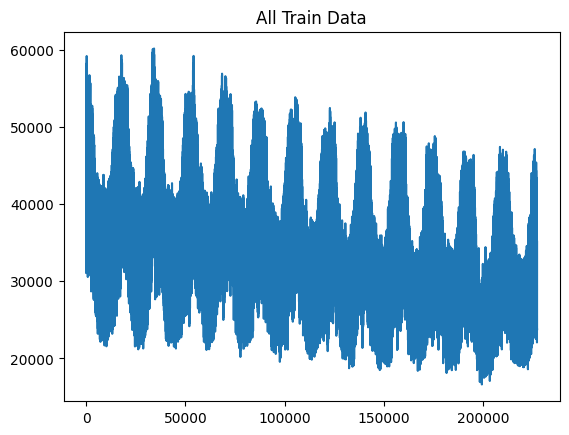

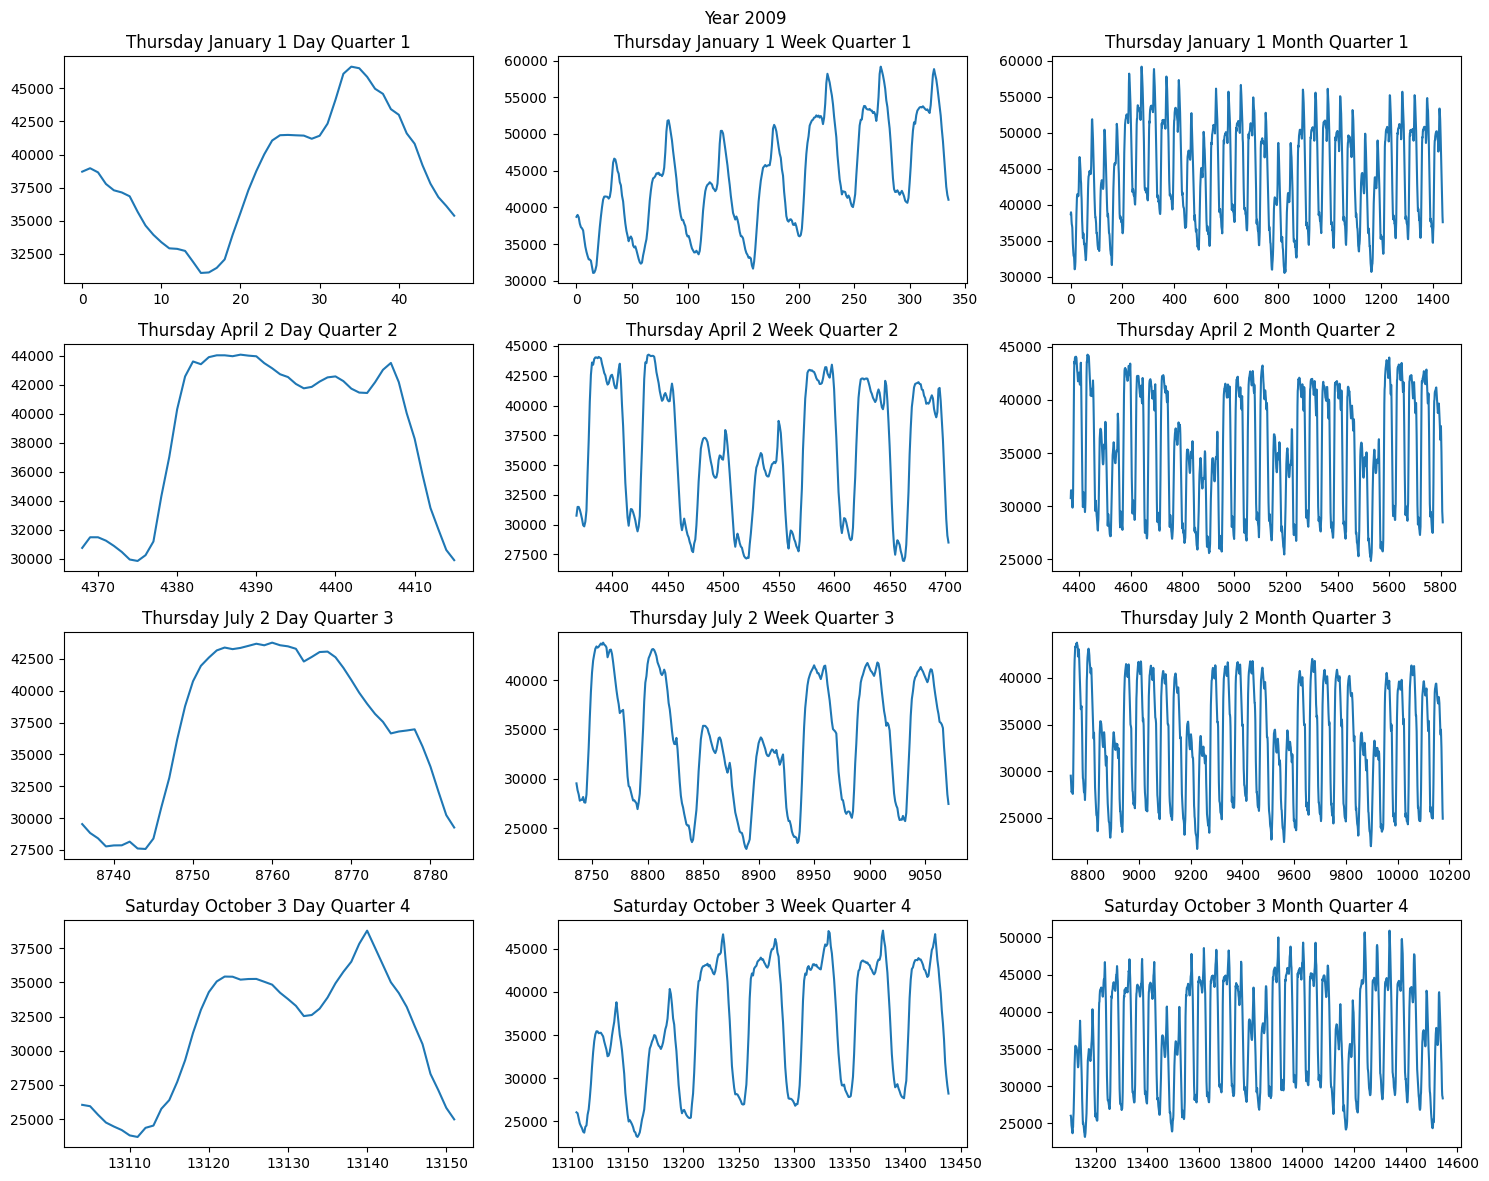

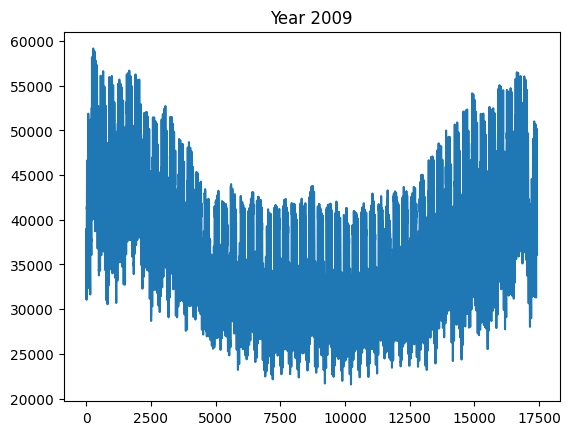

<Figure size 600x1200 with 0 Axes>

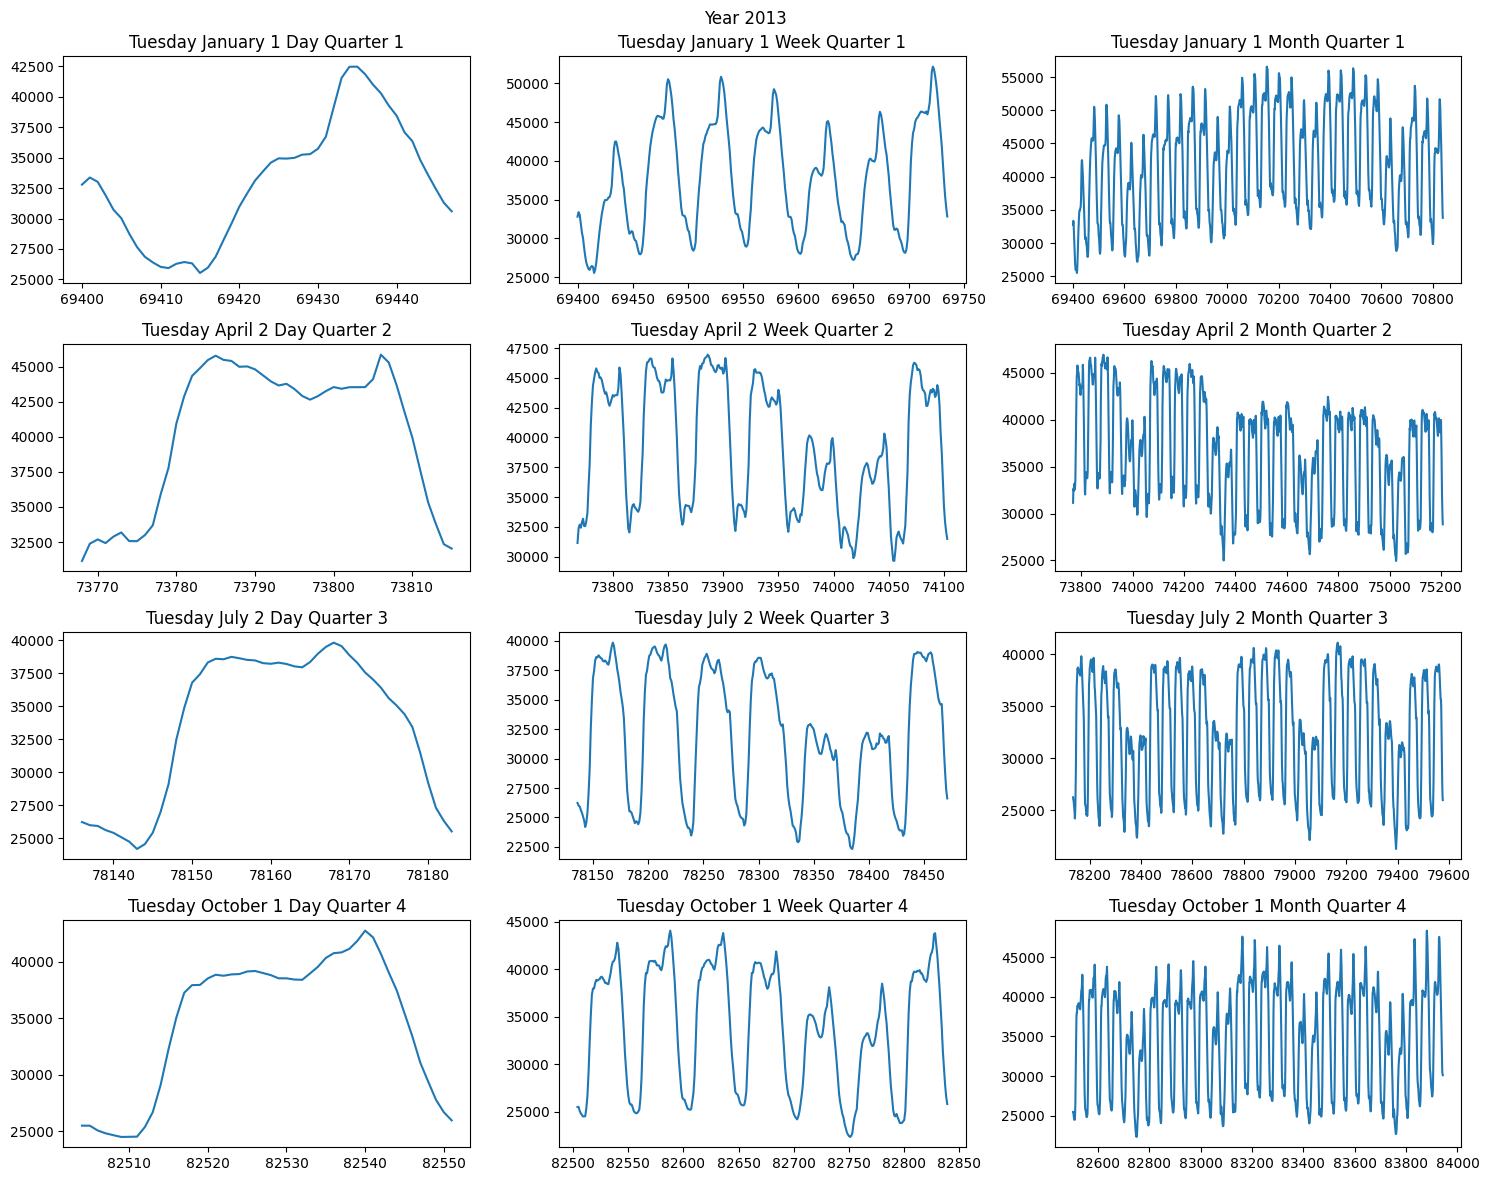

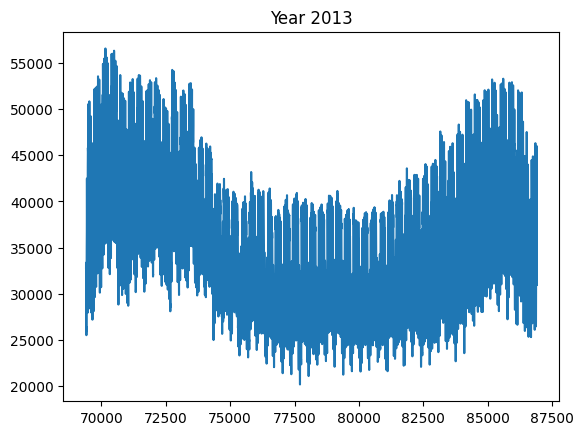

<Figure size 600x1200 with 0 Axes>

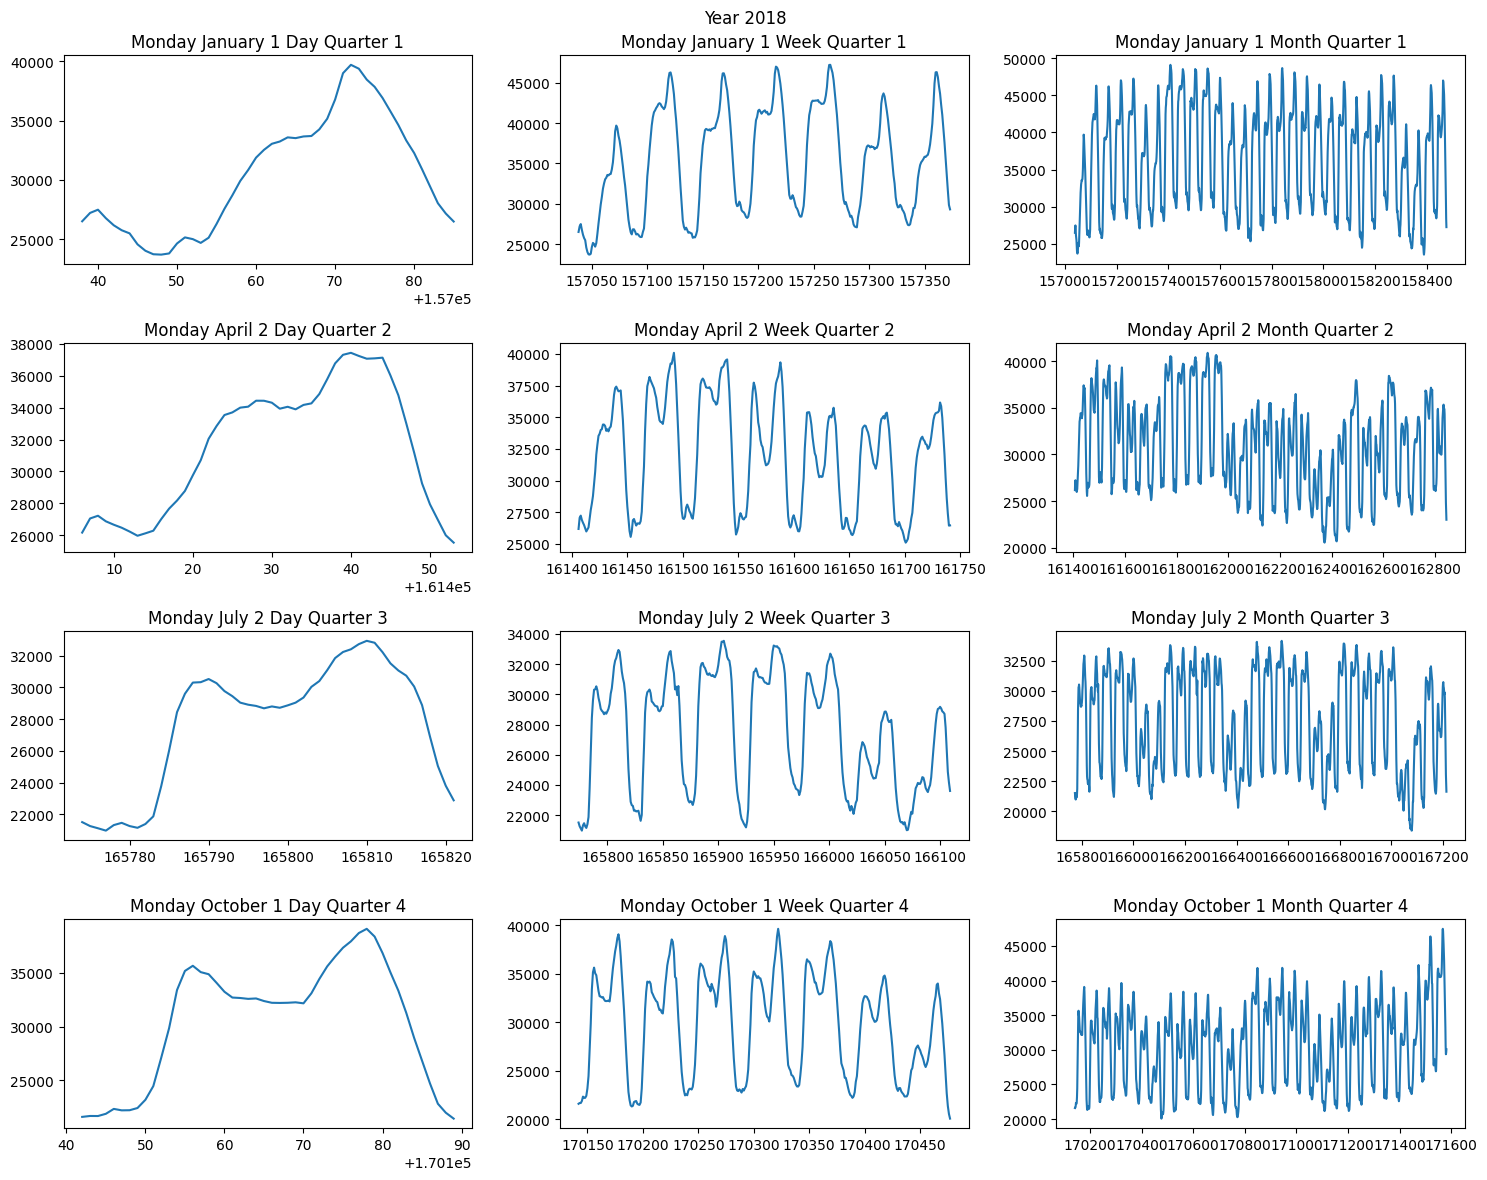

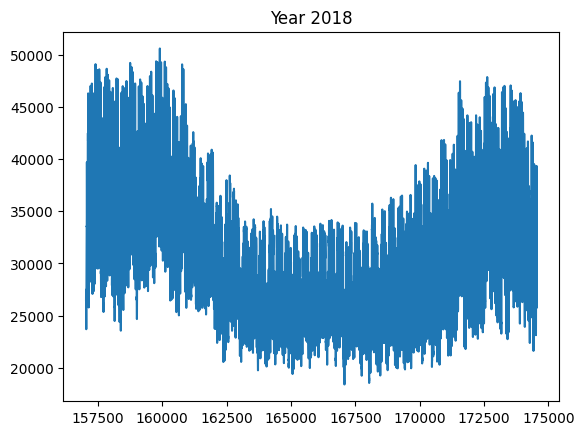

<Figure size 600x1200 with 0 Axes>

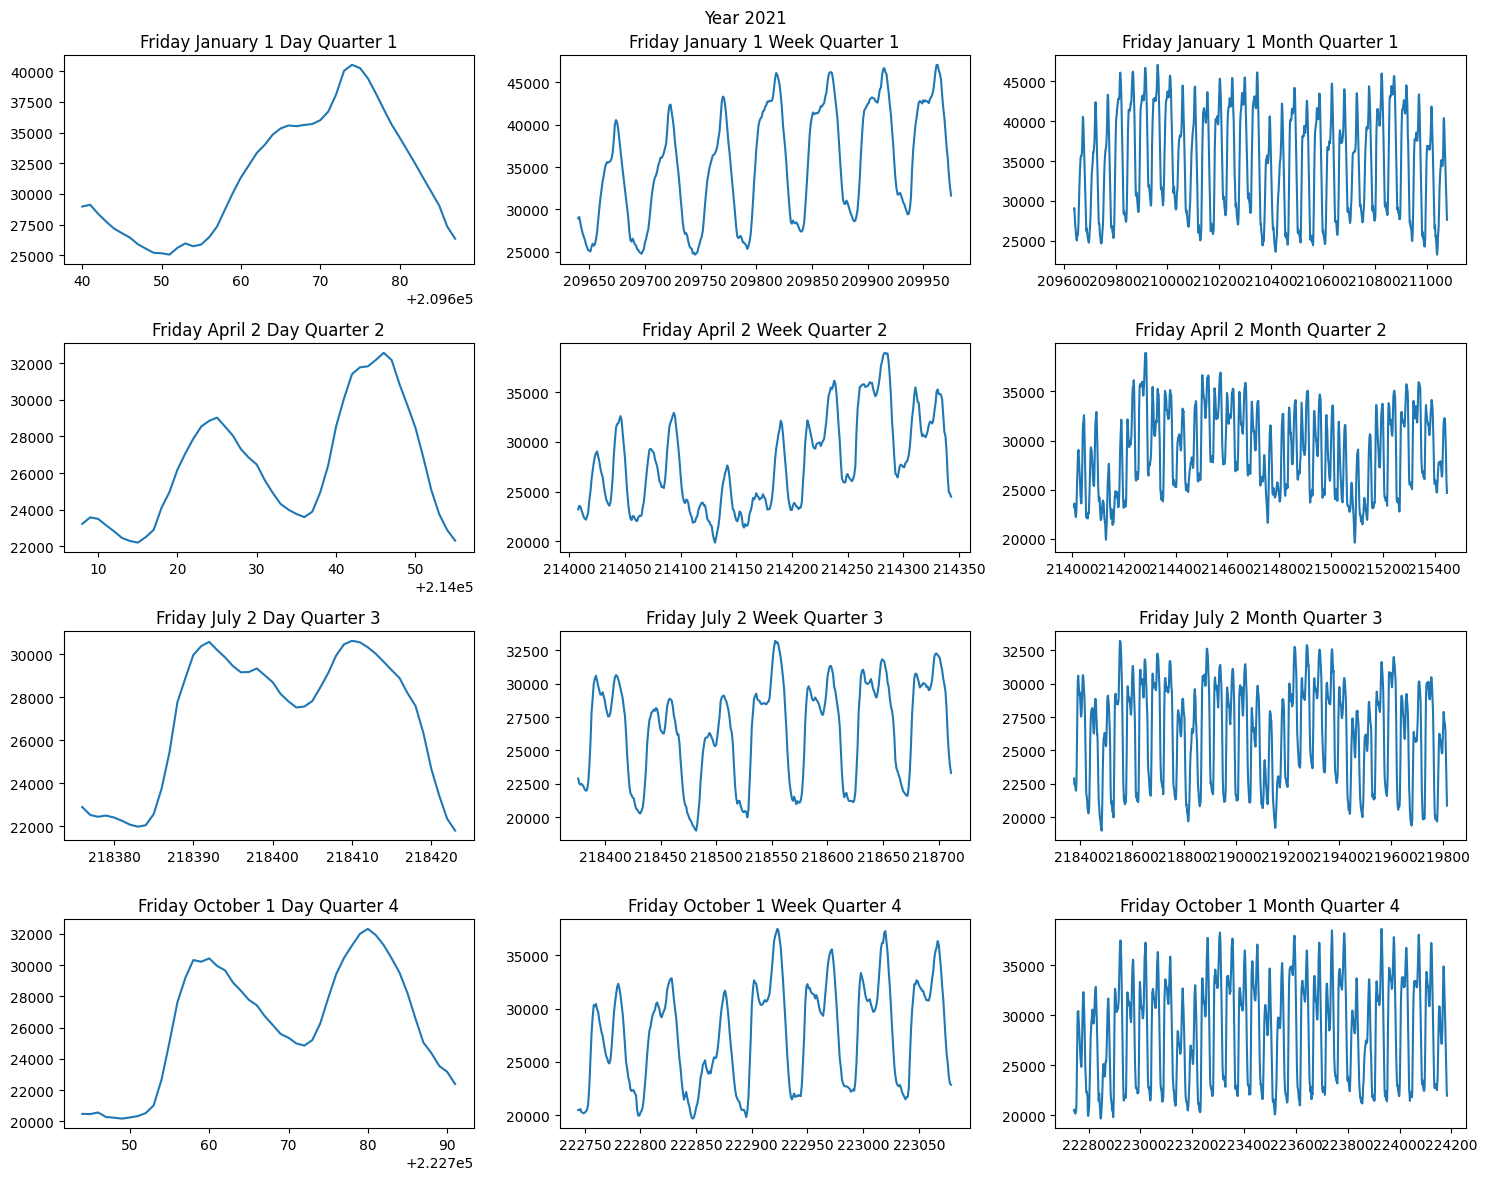

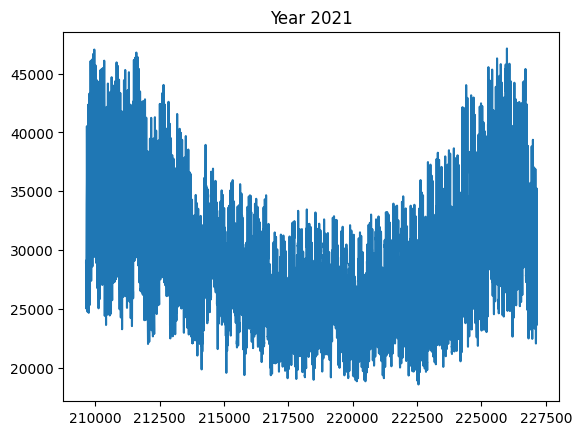

<Figure size 600x1200 with 0 Axes>

In [6]:
train_label_df.plot(title="All Train Data")
plt.show()

def analyse_year(data: pd.DataFrame, year: int):
    initial = data[data["settlement_date"].dt.year == year]
    target = initial["tsd"]

    fig, axes = plt.subplots(4, 3)

    fig.set_size_inches(15, 12)
    fig.suptitle(f"Year {year}")

    def get_day_info(day: int):
        index = ROWS_PER_DAY * day
        day = initial.iloc[index]["settlement_date"].day
        day_name = initial.iloc[index]["settlement_date"].day_name()
        month_name = initial.iloc[index]["settlement_date"].month_name()
        return f"{day_name} {month_name} {day}"

    def plot_in_ax(start_day, end_day, header, ax):
        target[start_day * ROWS_PER_DAY : end_day * ROWS_PER_DAY].plot(title = header, ax = ax)

    first_quarter_day = 0
    second_quarter_day = int(365 * 0.25)
    third_quarter_day = int(365 * 0.5)
    forth_quarter_day = int(365 * 0.75)

    for i, start_day in enumerate([first_quarter_day, second_quarter_day, third_quarter_day, forth_quarter_day]):
        day_info = get_day_info(start_day)
        plot_in_ax(start_day, start_day + 1, f"{day_info} Day Quarter {i + 1}", axes[i, 0])
        plot_in_ax(start_day, start_day + 7, f"{day_info} Week Quarter {i + 1}", axes[i, 1])
        plot_in_ax(start_day, start_day + 30, f"{day_info} Month Quarter {i + 1}", axes[i, 2])

    fig.tight_layout()
    plt.show()

    target.plot(title=f"Year {year}")
    plt.figure(figsize=(6,12))
    plt.tight_layout() 
    plt.show()

analyse_year(train_df, 2009)
analyse_year(train_df, 2013)
analyse_year(train_df, 2018)
analyse_year(train_df, 2021)

<Axes: >

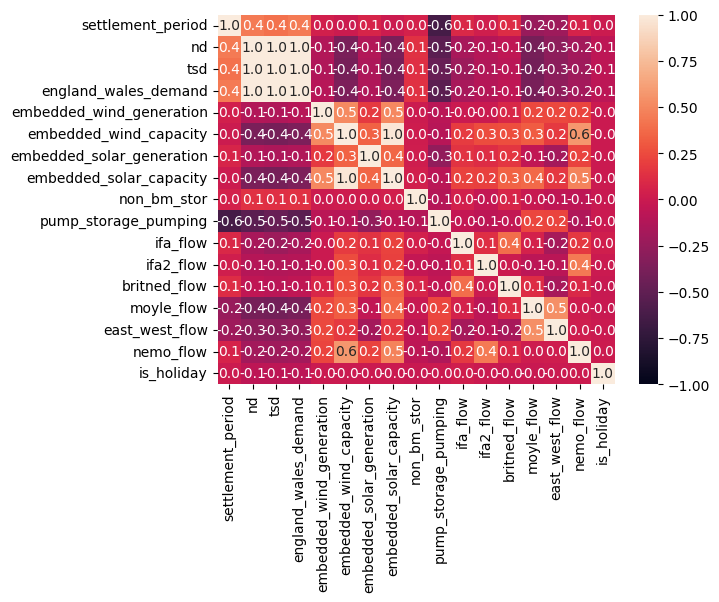

In [6]:
sns.heatmap(train_df.corr(numeric_only=True), robust=True, vmin=-1, vmax=1, annot=True, fmt=".1f")

## Preprocesamiento

- Creación de variables que indiquen:
  - Momento del año
  - Momento de la semana
  - Momento del día
- MinMaxScaler en las variables
- Eliminar información de fechas y horas
- Juntar los flujos entrantes y salientes en un solo vector Flow
- Quedarse con datos a partir de 2013

In [18]:

def get_final_df(df: pd.DataFrame):
    df = df.copy()

    flow_columns = ['ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow']
    df["flow"] = df[flow_columns].sum(axis=1)

    df["day_cycle"] = np.sin(df["settlement_period"] * 2 * np.pi / ROWS_PER_DAY)
    df["week_cycle"] = np.sin(df["settlement_date"].dt.dayofweek * 2 * np.pi / 7)
    df["year_cycle"] = np.sin(df["settlement_date"].dt.dayofyear * 2 * np.pi / 365)
    
    df = df[df["settlement_date"].dt.year >= 2013]
    
    drop = ["settlement_date", "settlement_period", "period_hour", *flow_columns]
    df = df.drop(drop, axis=1)
    return df

def fit_scalers(df: pd.DataFrame, columns: list):
    scaler = MinMaxScaler()
#     scaler = StandardScaler()
    scaler.fit(df[columns])
    return scaler

def transform_df_columns_with_scaler(df: pd.DataFrame, columns: list, scaler):
    df = df.copy()
    df[columns] = scaler.transform(df[columns])
    return df

final_train_df, final_validation_df, final_test_df = get_final_df(train_df), get_final_df(validation_df), get_final_df(test_df)
print(final_train_df.columns)

# Without 'is_holiday', 'day_cycle', 'week_cycle', 'year_cycle'
scaler_columns = ['nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation',
       'embedded_wind_capacity', 'embedded_solar_generation',
       'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping',
       'flow']

# Fit scalers only with train data
scaler = fit_scalers(final_train_df, scaler_columns)

final_train_df = transform_df_columns_with_scaler(final_train_df, scaler_columns, scaler)
final_validation_df = transform_df_columns_with_scaler(final_validation_df, scaler_columns, scaler)
final_test_df = transform_df_columns_with_scaler(final_test_df, scaler_columns, scaler)

final_train_df_path = Path("data", "final_train_df.csv")
final_validation_df_path = Path("data", "final_validation_df.csv")
final_test_df_path = Path("data", "final_test_df.csv")
scaler_path = Path("data", "scaler.obj")

final_train_df.to_csv(final_train_df_path)
final_validation_df.to_csv(final_validation_df_path)
final_test_df.to_csv(final_test_df_path)
with scaler_path.open("wb") as file:
    pickle.dump(scaler, file)

# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Values', data=final_train_df.melt(var_name="Column", value_name="Values")) 
# _ = ax.set_xticklabels(final_train_df.keys(), rotation=90)
# sns.heatmap(final_train_df.corr(numeric_only=True), robust=True, vmin=-1, vmax=1, annot=True, fmt=".1f")


Index(['nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation',
       'embedded_wind_capacity', 'embedded_solar_generation',
       'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping',
       'is_holiday', 'flow', 'day_cycle', 'week_cycle', 'year_cycle'],
      dtype='object')


## Cargar datos para modelo

In [2]:
final_train_df_path = Path("data", "final_train_df.csv")
final_validation_df_path = Path("data", "final_validation_df.csv")
final_test_df_path = Path("data", "final_test_df.csv")
scaler_path = Path("data", "scaler.obj")


final_train_df = pd.read_csv(final_train_df_path).drop("Unnamed: 0", axis=1)
final_validation_df = pd.read_csv(final_validation_df_path).drop("Unnamed: 0", axis=1)
final_test_df = pd.read_csv(final_test_df_path).drop("Unnamed: 0", axis=1)
scaler = pickle.load(scaler_path.open('rb'))

final_train_df.describe()

nd            tsd  england_wales_demand  \
count  157758.000000  157758.000000         157758.000000   
mean        0.412871       0.385992              0.559311   
std         0.172101       0.178656              0.131961   
min         0.000000       0.000000              0.000000   
25%         0.276626       0.245455              0.454591   
50%         0.398792       0.367794              0.548080   
75%         0.536169       0.510894              0.654248   
max         1.000000       1.000000              1.000000   

       embedded_wind_generation  embedded_wind_capacity  \
count             157758.000000           157758.000000   
mean                   0.255801                0.638036   
std                    0.176172                0.323138   
min                    0.000000                0.000000   
25%                    0.117867                0.435802   
50%                    0.212161                0.689746   
75%                    0.353789                0.928133   
max                    1.000000                1.000000   

       embedded_solar_generation  embedded_solar_capacity    non_bm_stor  \
count              157758.000000            157758.000000  157758.000000   
mean                    0.108696                 0.730381       0.014204   
std                     0.179697                 0.337794       0.070364   
min                     0.000000                 0.000000       0.000000   
25%                     0.000000                 0.582488       0.000000   
50%                     0.002479                 0.935893       0.000000   
75%                     0.154959                 1.000000       0.000000   
max                     1.000000                 1.000000       1.000000   

       pump_storage_pumping     is_holiday           flow     day_cycle  \
count         157758.000000  157758.000000  157758.000000  1.577580e+05   
mean               0.154744       0.021907       0.620199  7.446442e-06   
std                0.269565       0.146380       0.129430  7.071487e-01   
min                0.000000       0.000000       0.000000 -1.000000e+00   
25%                0.003992       0.000000       0.564092 -7.071068e-01   
50%                0.005988       0.000000       0.641848  1.224647e-16   
75%                0.172156       0.000000       0.700423  7.071068e-01   
max                1.000000       1.000000       1.000000  1.000000e+00   

          week_cycle    year_cycle  
count  157758.000000  1.577580e+05  
mean        0.000624 -1.033396e-04  
std         0.707086  7.068540e-01  
min        -0.974928 -9.999907e-01  
25%        -0.781831 -7.055836e-01  
50%         0.000000  6.432491e-16  
75%         0.781831  7.055836e-01  
max         0.974928  9.999907e-01

## Sampler

- Genera conjuntos de entrenamiento, validación y pruebas dados los DataFrames de los datos.
- Los conjuntos pueden ser generados con ventanas de diferentes tamaños tanto en el futuro como en el pasado.

In [3]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None, batch_size=32, sample_rate=1):
    # Store the raw data.
    self.train_df = train_df[train_df.index % sample_rate == 0]
    self.val_df = val_df[val_df.index % sample_rate == 0]
    self.test_df = test_df[test_df.index % sample_rate == 0]

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}
    
    self.batch_size = batch_size

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col="tsd", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=self.batch_size,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

# test_generator = WindowGenerator(ROWS_PER_DAY, ROWS_PER_DAY, ROWS_PER_DAY, final_test_df, final_validation_df, final_test_df)
# print(test_generator)
# test_generator.example[1]

## Entrenamiento

In [4]:
def get_metrics():
    return [
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.RootMeanSquaredError(),
    ]

def get_loss_function():
    return tf.keras.losses.MeanAbsoluteError()

def get_optimizer(learning_rate=0.001):
    return tf.keras.optimizers.Adam(learning_rate=learning_rate)

def compile_model(model):
    model.compile(optimizer=get_optimizer(), loss=get_loss_function(), metrics=get_metrics())

def compile_and_train_model(model, train_ds, val_ds, model_save_path=None, history_save_path=None, epochs=2, early_stopping_patience = 10):

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=early_stopping_patience),
        tf.keras.callbacks.ReduceLROnPlateau(patience=max(early_stopping_patience // 2, 2), min_lr=1e-5)
    ]
    if model_save_path:
        callbacks.append(tf.keras.callbacks.ModelCheckpoint(model_save_path, save_best_only=True))

    compile_model(model)

    history = model.fit(train_ds, validation_data=val_ds, callbacks=callbacks, epochs=epochs)

    if history_save_path:
        with Path(history_save_path).open("wb") as file:
            pickle.dump(history.history, file)

    return history.history


## Modelo

**Hipótesis:**

- El pasado es un buen predictor del futuro.
- El orden de los eventos tiene importancia.

**Características:**

- Los datos se toman por cada hora en vez de media hora.
- Se toma una ventana de contexto de 14 días.
- Se predicen las variables del próximo día.

**Posibles variantes:**

- Aumentar la ventana de contexto.
- Disminuir o aumentar la ventana a predecir.

In [5]:
# Take data each hour
SAMPLE_RATE = 2
# Predict one day in the future
FUTURE_DAYS = 1
ONE_SHOT_PREDICT_WINDOW = FUTURE_DAYS * ROWS_PER_DAY // SAMPLE_RATE 
# From 14 days of the past
PAST_DAYS = 14
ONE_SHOT_CONTEXT_WINDOW = PAST_DAYS * ROWS_PER_DAY // SAMPLE_RATE
FEATURES_PER_STEP = final_train_df.columns.size
EPOCHS = 100

conv_lstm_history_save = Path("models", "conv_lstm_history.obj")
conv_lstm_model_save = Path("models", "conv_lstm")


Total window size: 360
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

2023-07-29 03:08:57.467950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-29 03:08:57.497025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-29 03:08:57.497189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-29 03:08:57.499063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-29 03:08:57.499288: I tensorflow/compile

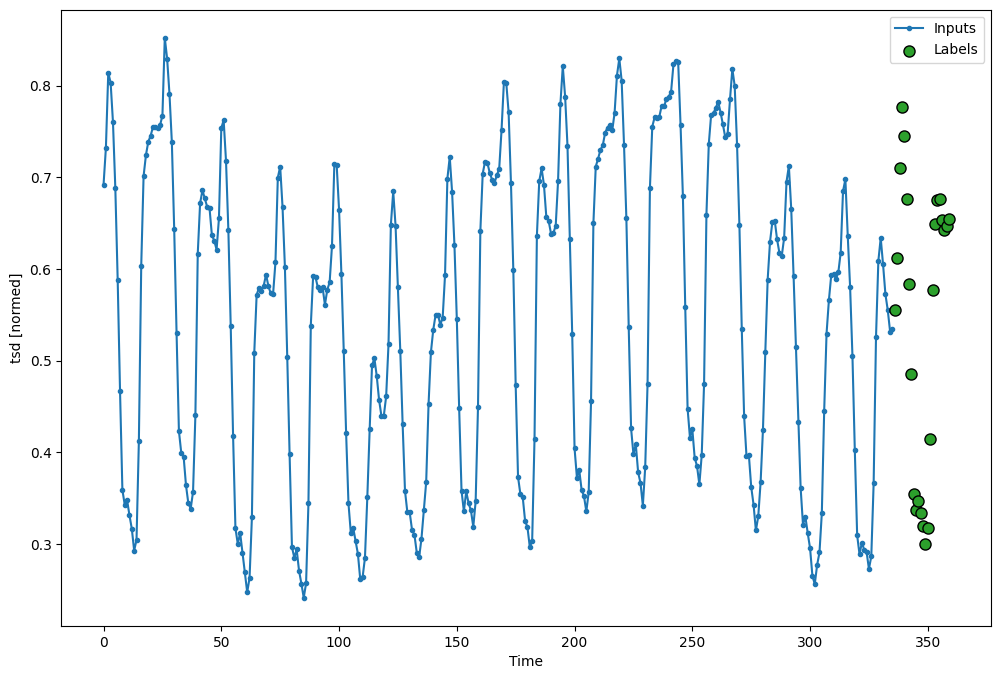

In [6]:
conv_lstm_window = WindowGenerator(
    ONE_SHOT_CONTEXT_WINDOW, 
    ONE_SHOT_PREDICT_WINDOW, 
    ONE_SHOT_PREDICT_WINDOW, 
    final_train_df, 
    final_validation_df, 
    final_test_df, 
    sample_rate=SAMPLE_RATE)
print(conv_lstm_window)
conv_lstm_window.plot(max_subplots=1)

### Modelo Conv LSTM

Se modela como un problema secuencia a secuencia en el cual dada la secuencia inicial de contexto se desea predecir la secuencia que le sigue a la entrada.

**Conv1D, Capas Pooling1D:**

- Dado una serie de elementos extrae información del segmento asociado.
- Utilizada para reducir la dimensión temporal de la serie

**LSTM:**

- Se alimenta de la serie paso a paso modificando su estado interno haciendo su salida dependiente de este.


In [29]:
def get_conv_lstm_model():
    input = tf.keras.Input((ONE_SHOT_CONTEXT_WINDOW, FEATURES_PER_STEP))
    model = tf.keras.Sequential([
        input,
        tf.keras.layers.Conv1D(32, kernel_size=6, activation="relu"),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(64, kernel_size=6, activation="relu"),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(128, kernel_size=6, activation="relu"),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.LSTM(256, return_sequences=True),
        tf.keras.layers.LSTM(FEATURES_PER_STEP, return_sequences=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(FEATURES_PER_STEP * ONE_SHOT_PREDICT_WINDOW),
        tf.keras.layers.Reshape((ONE_SHOT_PREDICT_WINDOW, FEATURES_PER_STEP)),
    ])
    return model

conv_lstm_model = get_conv_lstm_model()
conv_lstm_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 331, 32)           2720      
                                                                 
 max_pooling1d (MaxPooling1  (None, 165, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 160, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 80, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 75, 128)           49280     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 37, 128)           0

In [32]:

compile_and_train_model(
    conv_lstm_model, 
    conv_lstm_window.train, 
    conv_lstm_window.val, 
    epochs=EPOCHS, 
    model_save_path=str(conv_lstm_model_save), 
    history_save_path=str(conv_lstm_history_save),
)


Epoch 1/100


2023-07-28 21:54:43.015185: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x37a9a8b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-28 21:54:43.015294: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-07-28 21:54:43.122004: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-28 21:54:43.578454: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-07-28 21:54:45.636649: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more mem

2453/2454 [============================>.] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.0624 - mean_squared_error: 0.0175 - root_mean_squared_error: 0.1323

2023-07-28 21:55:13.280164: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2454/2454 [==============================] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.0623 - mean_squared_error: 0.0175 - root_mean_squared_error: 0.1322INFO:tensorflow:Assets written to: models/conv_lstm/assets


INFO:tensorflow:Assets written to: models/conv_lstm/assets


2454/2454 [==============================] - 40s 14ms/step - loss: 0.0623 - mean_absolute_error: 0.0623 - mean_squared_error: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0604 - val_mean_absolute_error: 0.0604 - val_mean_squared_error: 0.0129 - val_root_mean_squared_error: 0.1136 - lr: 0.0010
Epoch 2/100
2450/2454 [============================>.] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383 - mean_squared_error: 0.0066 - root_mean_squared_error: 0.0815INFO:tensorflow:Assets written to: models/conv_lstm/assets


INFO:tensorflow:Assets written to: models/conv_lstm/assets


2454/2454 [==============================] - 34s 14ms/step - loss: 0.0383 - mean_absolute_error: 0.0383 - mean_squared_error: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0543 - val_mean_absolute_error: 0.0543 - val_mean_squared_error: 0.0110 - val_root_mean_squared_error: 0.1049 - lr: 0.0010
Epoch 3/100
2454/2454 [==============================] - 31s 12ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - mean_squared_error: 0.0062 - root_mean_squared_error: 0.0787 - val_loss: 0.0571 - val_mean_absolute_error: 0.0571 - val_mean_squared_error: 0.0125 - val_root_mean_squared_error: 0.1116 - lr: 0.0010
Epoch 4/100
2454/2454 [==============================] - 31s 13ms/step - loss: 0.0335 - mean_absolute_error: 0.0335 - mean_squared_error: 0.0058 - root_mean_squared_error: 0.0760 - val_loss: 0.0577 - val_mean_absolute_error: 0.0577 - val_mean_squared_error: 0.0129 - val_root_mean_squared_error: 0.1138 - lr: 0.0010
Epoch 5/100
2454/2454 [==============================] - 31s 13m

{'loss': [0.06234491989016533,
  0.03830721601843834,
  0.03558121249079704,
  0.033476732671260834,
  0.031643096357584,
  0.029905755072832108,
  0.028414001688361168,
  0.024133848026394844,
  0.02371501922607422,
  0.023448217660188675,
  0.023202810436487198,
  0.022993236780166626],
 'mean_absolute_error': [0.06234487146139145,
  0.0383073091506958,
  0.035581208765506744,
  0.03347672149538994,
  0.03164307773113251,
  0.029905736446380615,
  0.028413981199264526,
  0.024133794009685516,
  0.02371497079730034,
  0.02344823069870472,
  0.023202843964099884,
  0.022993242368102074],
 'mean_squared_error': [0.017486942932009697,
  0.00663823913782835,
  0.0061902133747935295,
  0.005777520593255758,
  0.005391374696046114,
  0.005039316136389971,
  0.004747170489281416,
  0.004360060207545757,
  0.004307986237108707,
  0.004272151738405228,
  0.004238765221089125,
  0.00421028770506382],
 'root_mean_squared_error': [0.1322382241487503,
  0.08147541433572769,
  0.07867797464132309,


In [7]:
conv_lstm_model = tf.keras.models.load_model(str(conv_lstm_model_save))
with conv_lstm_history_save.open('rb') as file:
    conv_lstm_history = pickle.load(file)

### Modelo repite datos

El modelo repite los datos sacados de la ventana de entrada. Se crean dos modelos:

- Repite el día anterior
- Repite el día de la semana anterior al que le toca predecir


In [8]:
class RepeatBeforeModel(tf.keras.Model):
    
    def __init__(self, start_index, offset):
        super().__init__()
        self.start_index = start_index
        self.offset = offset
        
    def call(self, input, **kwargs):
        return input[:,self.start_index:self.start_index+self.offset,:]

week_model = RepeatBeforeModel(7 * ROWS_PER_DAY // SAMPLE_RATE, ONE_SHOT_PREDICT_WINDOW)
day_model = RepeatBeforeModel(13 * ROWS_PER_DAY // SAMPLE_RATE, ONE_SHOT_PREDICT_WINDOW)

In [9]:

compile_and_train_model(week_model, conv_lstm_window.train, conv_lstm_window.val, epochs=1)
compile_and_train_model(day_model, conv_lstm_window.train, conv_lstm_window.val, epochs=1)


2454/2454 [==============================] - 9s 4ms/step - loss: 0.0742 - mean_absolute_error: 0.0742 - mean_squared_error: 0.0355 - root_mean_squared_error: 0.1884 - val_loss: 0.0801 - val_mean_absolute_error: 0.0801 - val_mean_squared_error: 0.0377 - val_root_mean_squared_error: 0.1941 - lr: 0.0010


{'loss': [0.0742277204990387],
 'mean_absolute_error': [0.0742277055978775],
 'mean_squared_error': [0.03549100458621979],
 'root_mean_squared_error': [0.18839044868946075],
 'val_loss': [0.08007965236902237],
 'val_mean_absolute_error': [0.08007965236902237],
 'val_mean_squared_error': [0.03766197711229324],
 'val_root_mean_squared_error': [0.19406689703464508],
 'lr': [0.001]}

## Evaluación de entrenamiento

**Conv y LSTM**
- El modelo deja de aprender relativamente temprano.
- Las métricas de validación se mantienen constantes luego de cierto punto y no se muestra un aumento a medida que pasa el entrenamiento.



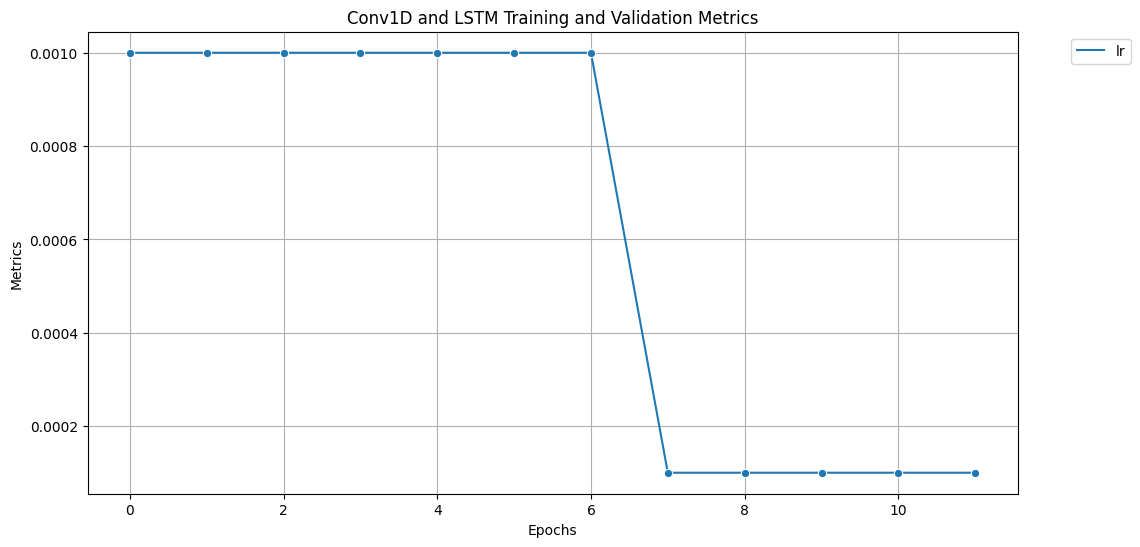

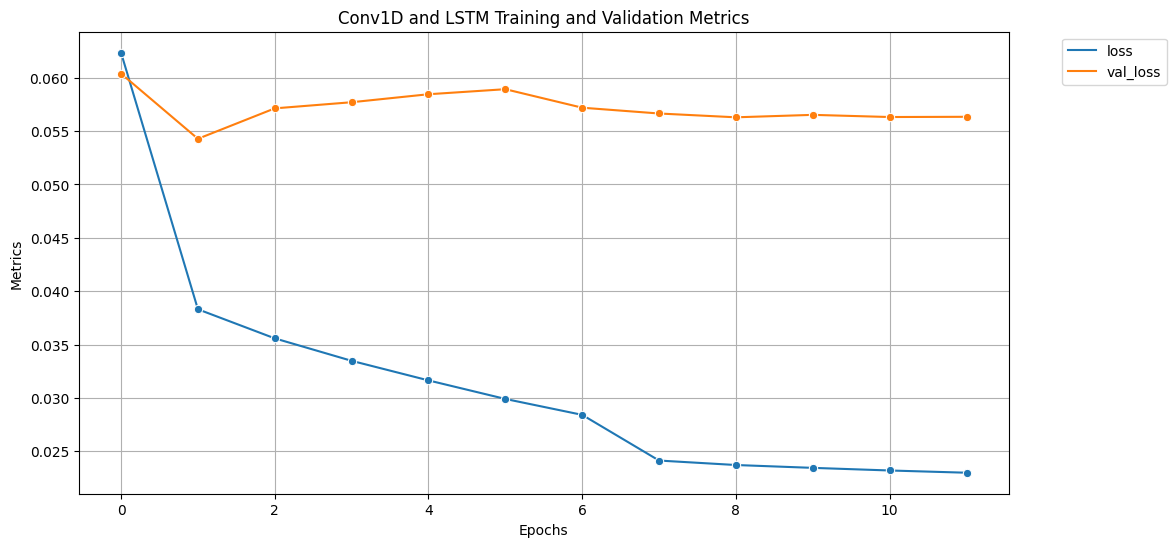

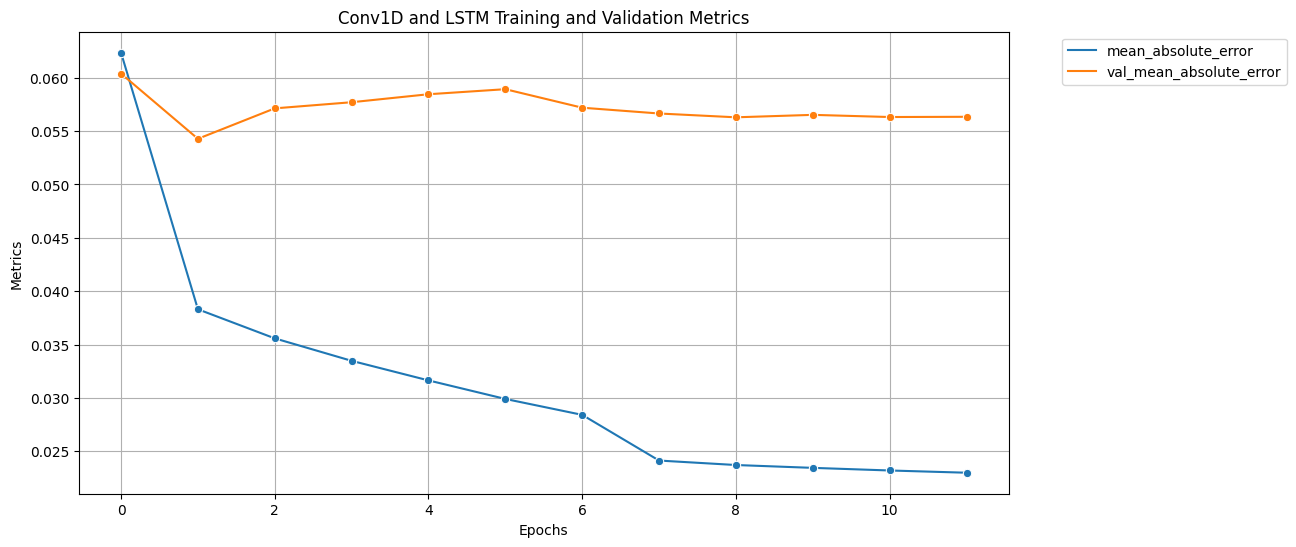

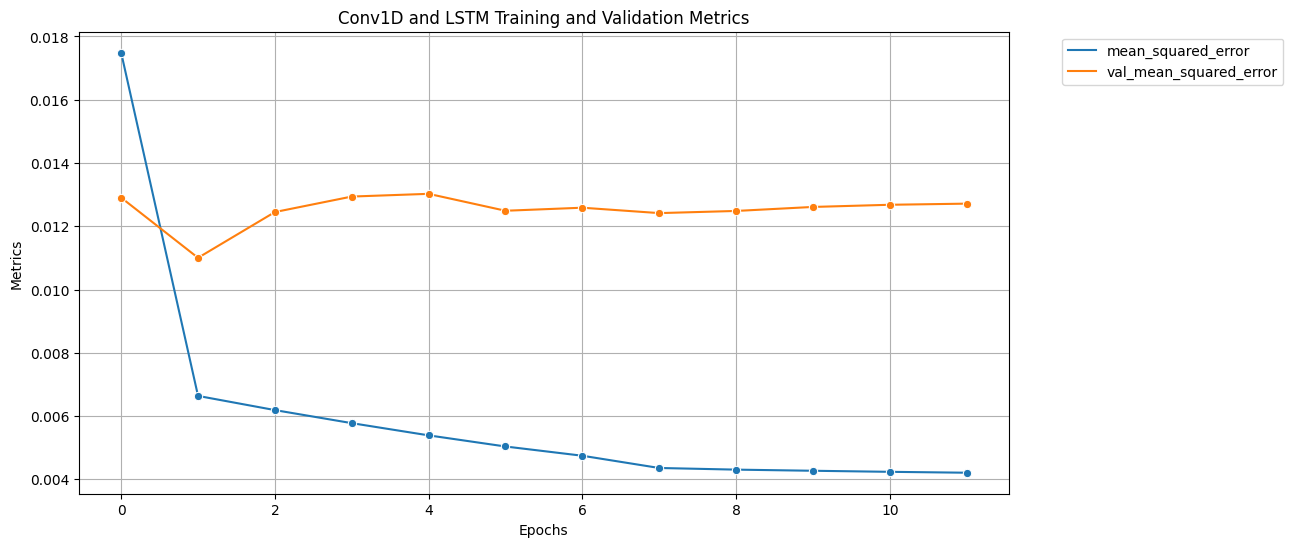

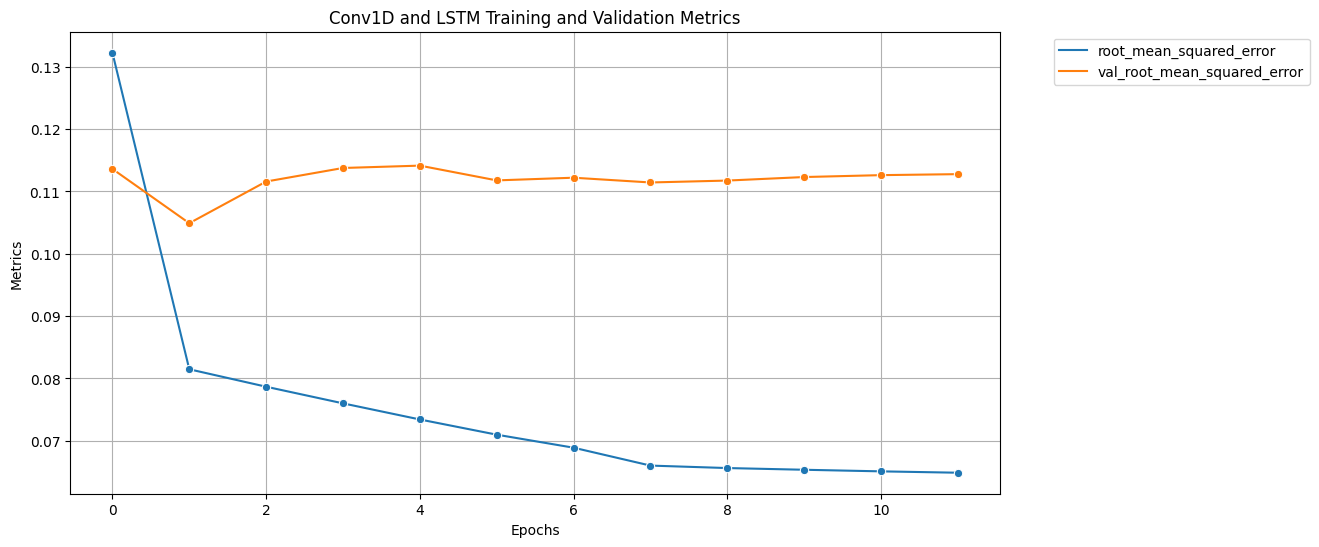

In [16]:
def plot_training(history, header):
    """
    Receives a training history and plot the metrics against epochs.
    
    history: Dictionary returned by fit method.
    """
    # Convert the data dictionary to a DataFrame
    history = history.copy()

    df = pd.DataFrame(history)

    # Melt the DataFrame to restructure the data for Seaborn
    df_melted = df.melt('Epochs', var_name='Metrics', value_name='Values')

    # Plot each metric comparing training and validation values over epochs
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Epochs', y='Values', hue='Metrics', marker='o', data=df_melted)
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title(f'{header} Training and Validation Metrics')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

def plot_evaluation_metrics(metric_dict):
    df = pd.DataFrame({x: [metric_dict[x]] for x in metric_dict})
    sns.barplot(data=df)
    plt.xticks(rotation=45)
    plt.show()

def get_training_plots(history, with_lr = False):
    """
    Return a list of dictionaries to be plotted
    """
    history = history.copy()
    
    history["Epochs"] = [i for i in range(len(history['loss']))]

    pre_metrics = []
    if with_lr:
        pre_metrics.append({x: history[x] for x in ["Epochs", "lr"]})

    return [
        *pre_metrics,
        {x: history[x] for x in ["Epochs", "loss", "val_loss"]},
        {x: history[x] for x in ["Epochs", "mean_absolute_error", "val_mean_absolute_error"]},
        {x: history[x] for x in ["Epochs", "mean_squared_error", "val_mean_squared_error"]},
        {x: history[x] for x in ["Epochs", "root_mean_squared_error", "val_root_mean_squared_error"]},
    ]


for subhistory in get_training_plots(conv_lstm_history, with_lr=True):
    plot_training(subhistory, "Conv1D and LSTM")



## Evaluación del modelo

El modelo conformado por capas convolucionales y LSTM supera a la heurística de devolver los datos del día de la semana anterior.

| Modelo | MAE | MSE | RMSE |
| --- | --- | --- | --- |
| Day | 0.0742 | 0.0354 | 0.1883 |
| Week | 0.0434 | 0.0105 | 0.1025 |
| ConvLSTM | **0.0365** | **0.006** | **0.0794** |


In [17]:
conv_lstm_eval_dict = conv_lstm_model.evaluate(conv_lstm_window.train, return_dict=True)
week_eval_dict = week_model.evaluate(conv_lstm_window.train, return_dict=True)
day_eval_dict = day_model.evaluate(conv_lstm_window.train, return_dict=True)

print(conv_lstm_eval_dict)
print(week_eval_dict)
print(day_eval_dict)

2454/2454 [==============================] - 8s 3ms/step - loss: 0.0742 - mean_absolute_error: 0.0742 - mean_squared_error: 0.0355 - root_mean_squared_error: 0.1884
{'loss': 0.03652132675051689, 'mean_absolute_error': 0.036521345376968384, 'mean_squared_error': 0.006305212154984474, 'root_mean_squared_error': 0.07940535992383957}
{'loss': 0.04346420615911484, 'mean_absolute_error': 0.04346419870853424, 'mean_squared_error': 0.010521786287426949, 'root_mean_squared_error': 0.10257573425769806}
{'loss': 0.07422774285078049, 'mean_absolute_error': 0.07422784715890884, 'mean_squared_error': 0.0354909747838974, 'root_mean_squared_error': 0.18839050829410553}


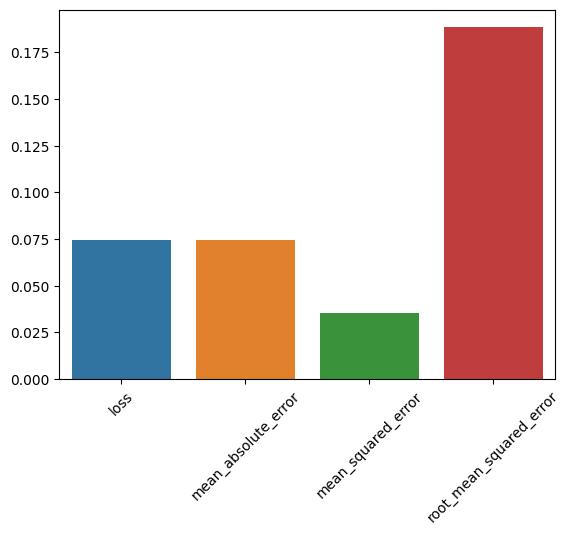

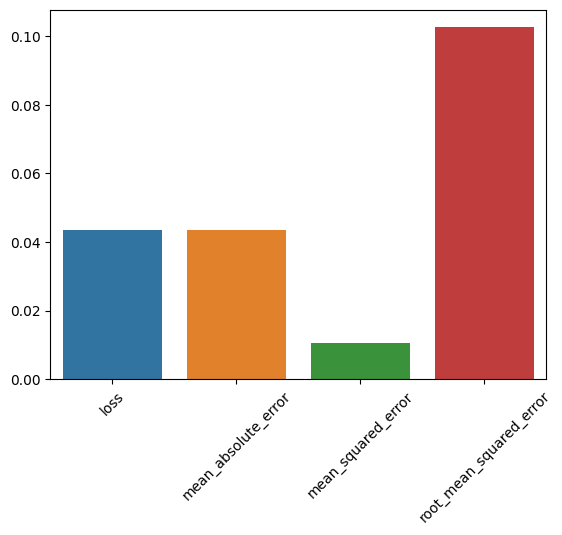

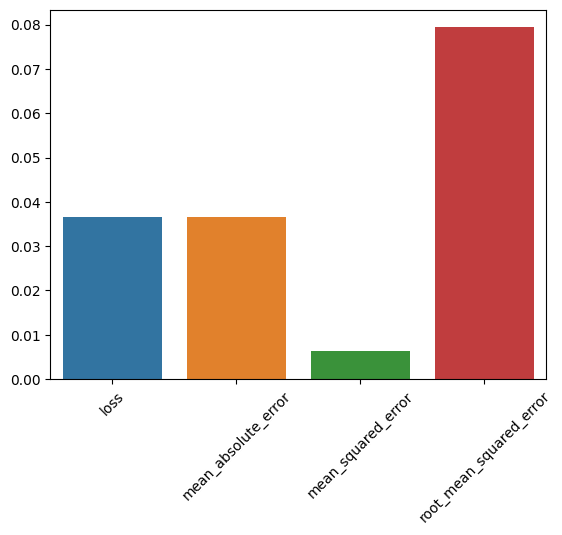

In [18]:
plot_evaluation_metrics(day_eval_dict)
plot_evaluation_metrics(week_eval_dict)
plot_evaluation_metrics(conv_lstm_eval_dict)


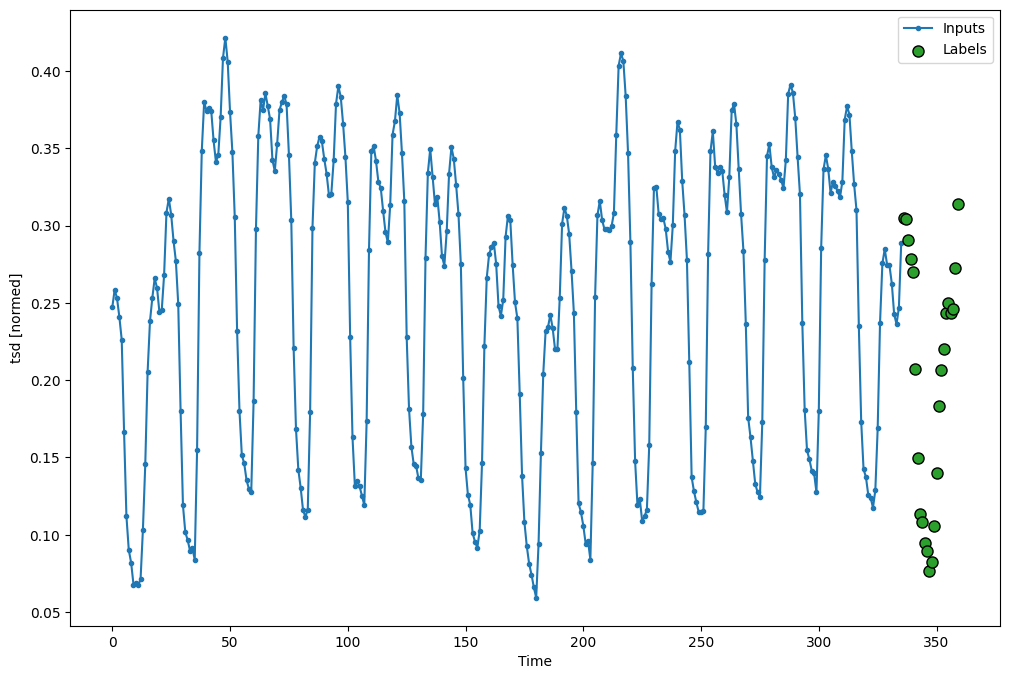

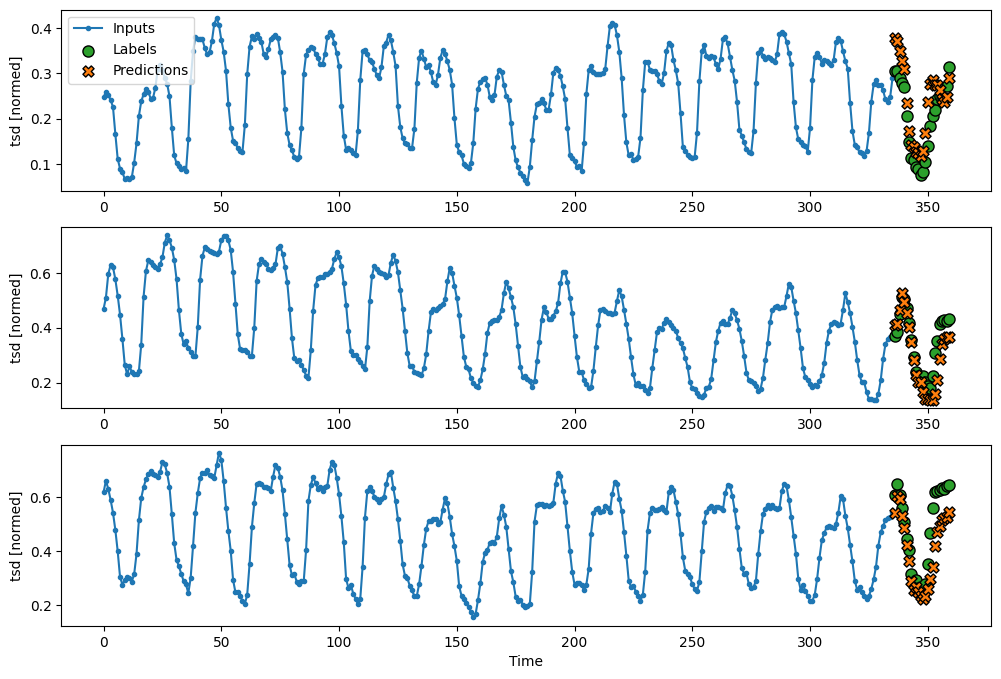

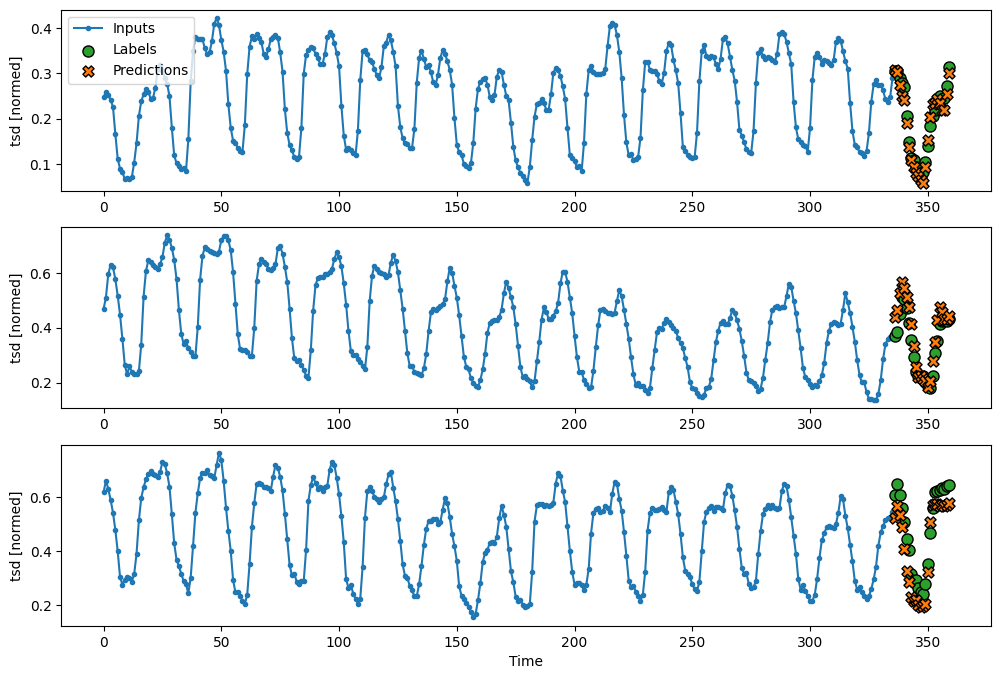

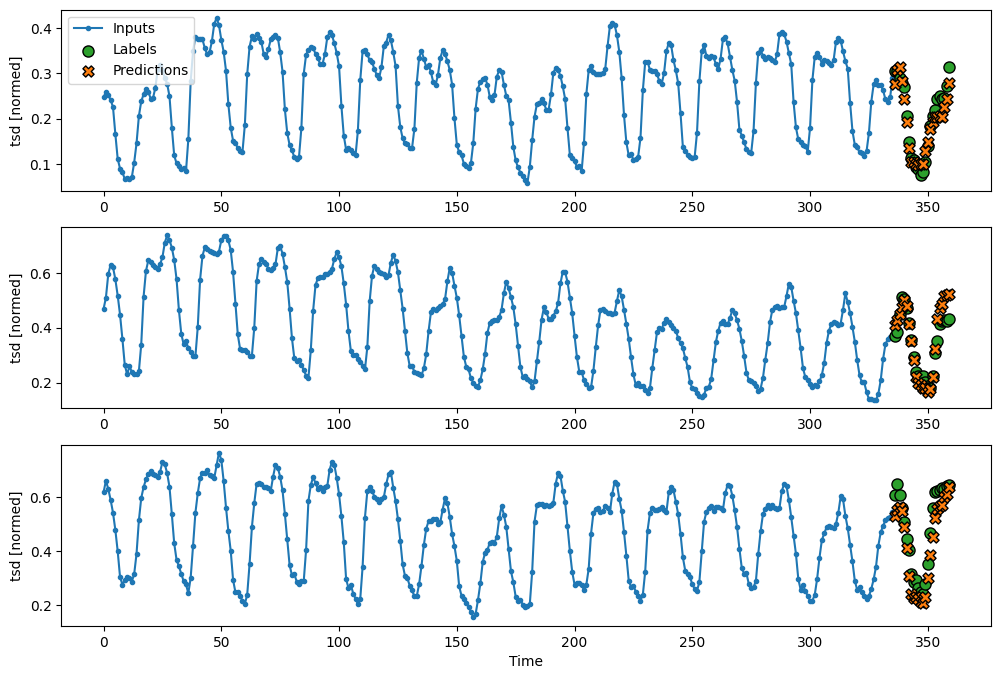

In [19]:
conv_lstm_window.plot(max_subplots=1)
conv_lstm_window.plot(day_model)
conv_lstm_window.plot(week_model)
conv_lstm_window.plot(conv_lstm_model)


### Análisis de residuos

- La gráfica de residuos muestra que se mantienen en una franja con entre -0.06 y 0.06 con media cercana a 0. 
- La gráfica QQ muestra que los datos se encuentran cercanos a sus cuantiles teóricos.
- El histograma de distribución de errores muestra una curva similar a una distribución normal.
- Los test de normalidad devuelven que los errores probablemente no pertenecen a una distribución normal.

In [91]:
from typing import Literal
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import norm
    
def compute_error(predicted_values, true_values, metric: Literal["mse", "rmse", "mae"]):
    """
    Returns the `metric` value given `predicted_values` and `true_values`.
    """
    if metric == "mae":
        return mean_absolute_error(true_values, predicted_values)
    if metric == "mse":
        return mean_squared_error(true_values, predicted_values)
    if metric == "rmse":
        return mean_squared_error(true_values, predicted_values, squared=False)

def residual_analysis(predicted_values, true_values, ylimits=5, bins=100, norm_xlim = 0.6):
    """
    Print and plots a residual analysis given `predicted_values` and `true_values`
    """

    residuals = true_values - predicted_values

    plt.scatter([i for i in range(len(residuals))], residuals, label="Error")
    plt.grid(True)
    plt.ylim(-ylimits, ylimits)
    plt.title("Residual Errors")
    plt.legend()
    plt.show()
    
    mean = np.mean(residuals)
    std = np.std(residuals)
    print("Mean", mean)
    print("Standard deviation", std)
    
    plt.hist(residuals, bins=bins)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')
    plt.show()

    # QQ plot
    qq = stats.probplot(residuals, dist='norm', plot=plt)
    plt.title('QQ plot of Residuals')
    plt.show()
    
    
    if len(residuals) > 4500:
        print("Samples are to big, reducing to 4500 randomly selected items")
        residuals = random.sample(list(residuals), 4500)

    shapiro = stats.shapiro(residuals)[1]
    anderson = stats.anderson(residuals)
    dagostino = stats.normaltest(residuals)[1]

    print('Shapiro-Wilk test p-value:', shapiro)
    if shapiro < 0.05:
        print("The residuals are likely not normal")
    else:
        print("The residuals are likely normal")

    print('DAgostino K-squared test p-value:', dagostino)
    if dagostino < 0.05:
        print("The residuals are likely not normal")
    else:
        print("The residuals are likely normal")

    print('Anderson-Darling test:')
    print(anderson.critical_values)
    print(anderson.statistic)
    print(anderson.significance_level)



In [149]:
day_predictions = day_model.predict(conv_lstm_window.test)
week_predictions = week_model.predict(conv_lstm_window.test)
conv_lstm_predictions = conv_lstm_model.predict(conv_lstm_window.test)

75/75 [==============================] - 1s 4ms/step


In [151]:
def unroll_tensor_to_tsd(tensor, tsd_index=1):
    return tf.reshape(tensor, (tf.shape(tensor)[0] * tf.shape(tensor)[1], tf.shape(tensor)[2]))[:, tsd_index]

true_unrolled = unroll_tensor_to_tsd(tf.concat(list(conv_lstm_window.test.map(lambda x, y: y)), 0))
day_unrolled = unroll_tensor_to_tsd(day_predictions)
week_unrolled = unroll_tensor_to_tsd(week_predictions)
conv_lstm_unrolled = unroll_tensor_to_tsd(conv_lstm_predictions)


Day Residual Analysis


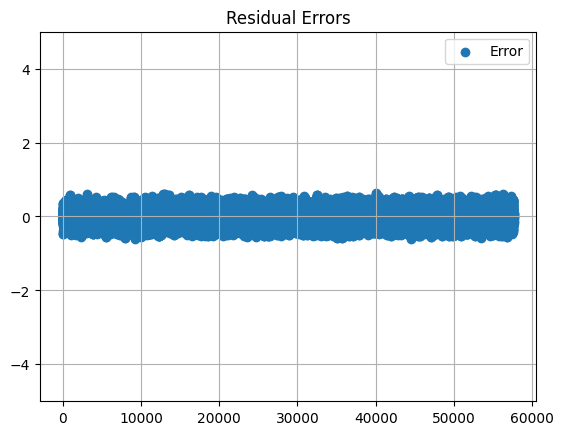

Mean 3.0699123e-06
Standard deviation 0.2001219


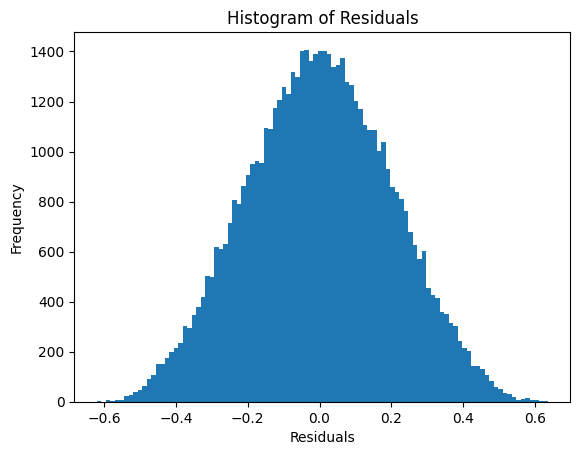

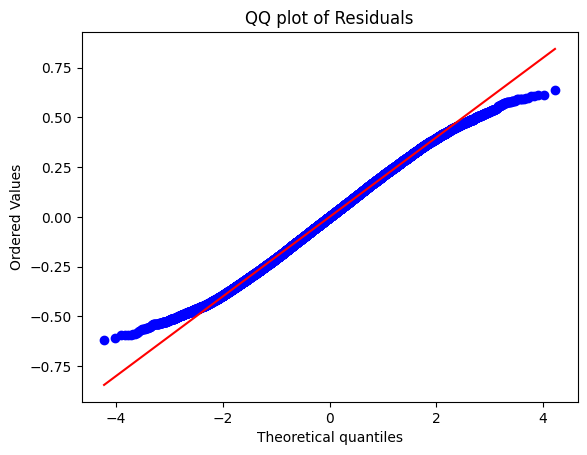

Samples are to big, reducing to 4500 randomly selected items
Shapiro-Wilk test p-value: 1.5055437074806832e-07
The residuals are likely not normal
DAgostino K-squared test p-value: 1.5397138074490815e-11
The residuals are likely not normal
Anderson-Darling test:
[0.575 0.655 0.786 0.917 1.091]
1.88815730587703
[15.  10.   5.   2.5  1. ]
Week Residual Analysis


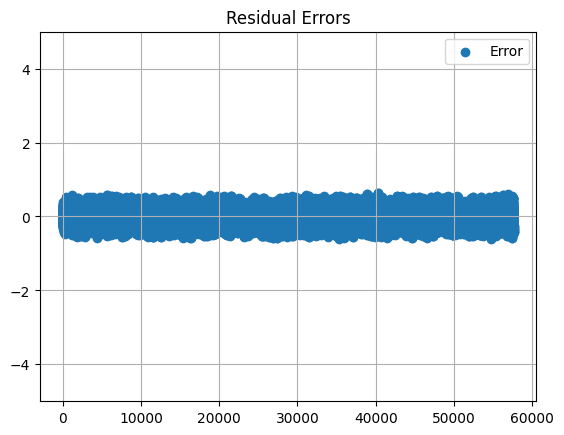

Mean -0.0074876584
Standard deviation 0.20148723


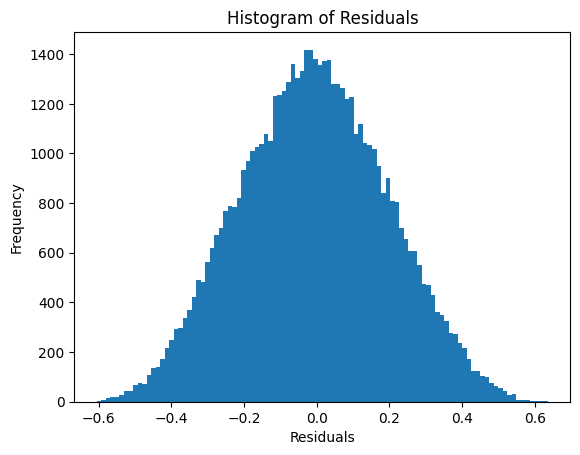

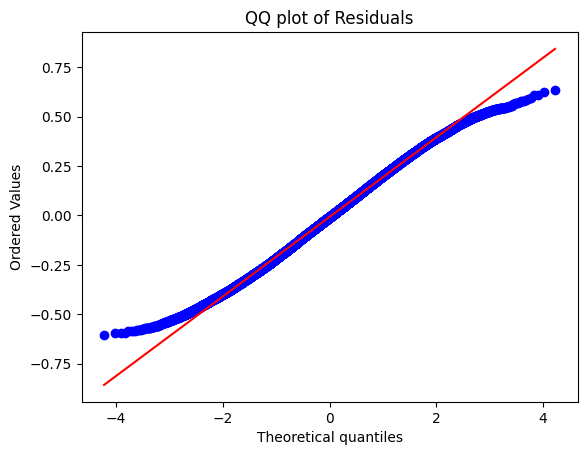

Samples are to big, reducing to 4500 randomly selected items
Shapiro-Wilk test p-value: 2.589961489718462e-08
The residuals are likely not normal
DAgostino K-squared test p-value: 3.053745049957565e-13
The residuals are likely not normal
Anderson-Darling test:
[0.575 0.655 0.786 0.917 1.091]
1.8996156864732257
[15.  10.   5.   2.5  1. ]
ConvLSTM Residual Analysis


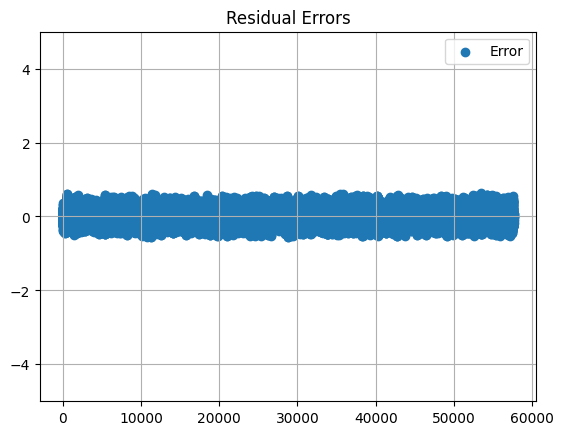

Mean 0.0073550367
Standard deviation 0.19276622


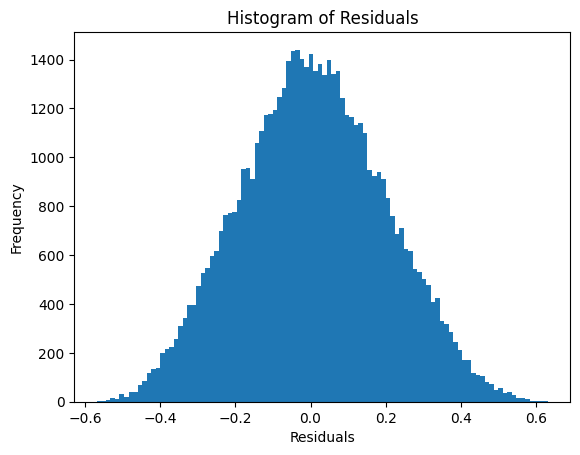

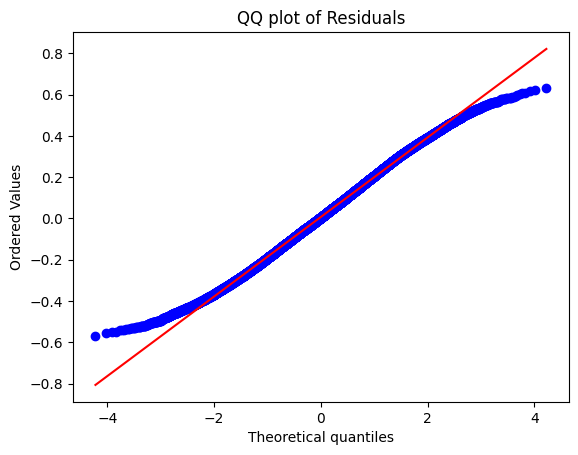

Samples are to big, reducing to 4500 randomly selected items
Shapiro-Wilk test p-value: 7.796678858085215e-08
The residuals are likely not normal
DAgostino K-squared test p-value: 2.5727398327210475e-10
The residuals are likely not normal
Anderson-Darling test:
[0.575 0.655 0.786 0.917 1.091]
2.0966026294272524
[15.  10.   5.   2.5  1. ]


In [152]:
print("Day Residual Analysis")
residual_analysis(day_unrolled, true_unrolled)
print("Week Residual Analysis")
residual_analysis(week_unrolled, true_unrolled)
print("ConvLSTM Residual Analysis")
residual_analysis(conv_lstm_unrolled, true_unrolled)



## Predicción 2023

Se utilizarán los modelos propuestos para predecir la demanda de 2023 en su totalidad. Se parte de las primeras semanas del año 2023 como contexto para la generación. 


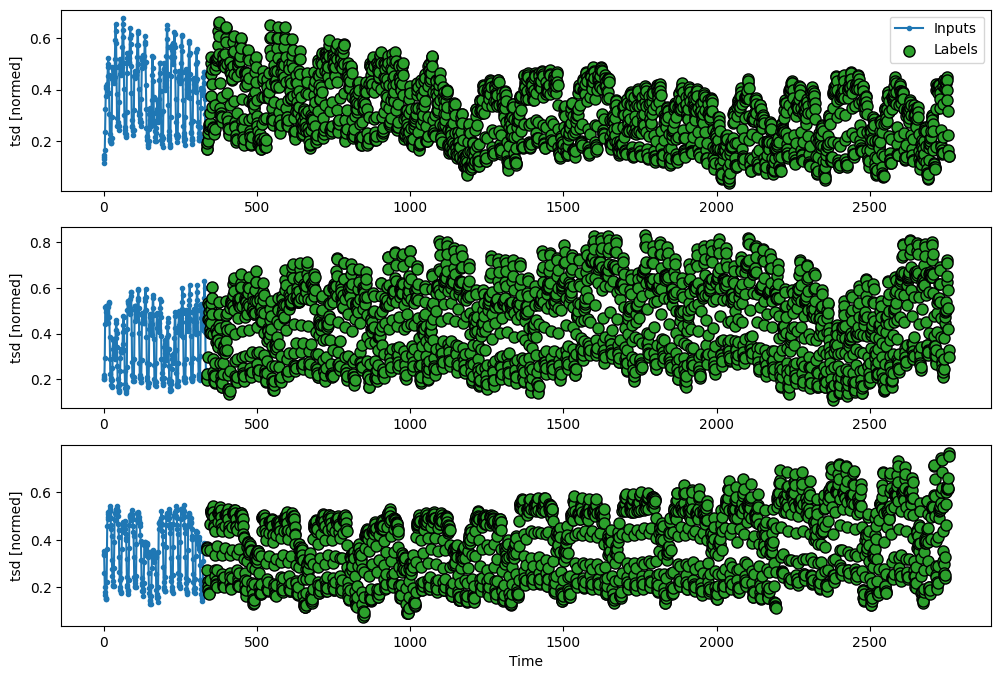

In [111]:

def stack_predictions(warmup, steps, model, take=None):
    """
    Return the autorregresive predictions for `model`.
    
    warmup: Initial data to get the first prediction.
    steps: Amount of predictions to get
    model: Model to get the predictions
    take: How many steps take from prediction to add to the forecast
    
    returns: List of predictions made by model.
    """
    forecast = []
    input_ = warmup
    for _ in range(steps):
        f = model(input_)
        if take:
            f = f[:,:take,:]
        forecast.append(f[0])
        shape = tf.shape(f)[1]
        input_ = tf.concat([input_[:,shape:,:], f], axis=1)
    return forecast

DAYS_SAMPLES_2023 = 100 * ROWS_PER_DAY // SAMPLE_RATE + 23
predict_2023_window = WindowGenerator(
    ONE_SHOT_CONTEXT_WINDOW, 
    DAYS_SAMPLES_2023, 
    DAYS_SAMPLES_2023, 
    final_train_df, 
    final_validation_df, 
    final_test_df, 
    sample_rate=SAMPLE_RATE)
predict_2023_window.plot()


In [116]:
test_2023_warmup, test_2023_rest = list(predict_2023_window.test)[0]

def get_autorregresive_predictions(model, context, days=101, tsd_index=1, take=None):
    return tf.concat(stack_predictions(context, days, model, take=take), axis=0)[:-1, tsd_index]

# TSD variable for context and rest of year
test_2023_warmup_tsd = tf.reshape(test_2023_warmup, (tf.shape(test_2023_warmup)[1:]))[:, 1] # Get TSD variable
test_2023_rest_tsd = tf.reshape(test_2023_rest, (tf.shape(test_2023_rest)[1:]))[:, 1] # Get TSD variable

# TSD predictions
day_2023_predictions = get_autorregresive_predictions(day_model, test_2023_warmup)
week_2023_predictions = get_autorregresive_predictions(week_model, test_2023_warmup)
conv_lstm_2023_predictions = get_autorregresive_predictions(conv_lstm_model, test_2023_warmup)

# Instead of predicting the whole day only predict the next hour
conv_lstm_2023_hour_predictions = get_autorregresive_predictions(conv_lstm_model, test_2023_warmup, days=101 * 24, take=1)


Day prediction {'mse': 0.015426497, 'mae': 0.09744537, 'rmse': 0.12420345}
Week prediction {'mse': 0.010295013, 'mae': 0.07995157, 'rmse': 0.101464346}
Day ConvLSTM prediction {'mse': 0.009272929, 'mae': 0.076261096, 'rmse': 0.09629605}
Hour ConvLSTM prediction {'mse': 0.018817095, 'mae': 0.11251048, 'rmse': 0.13717541}
Day prediction


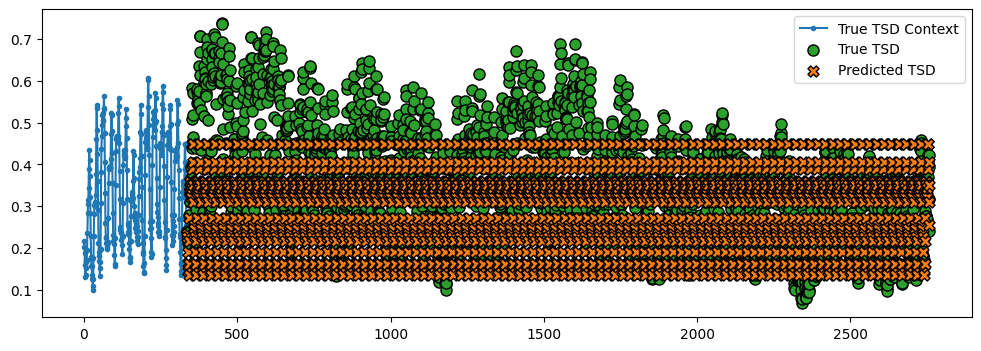

Week prediction


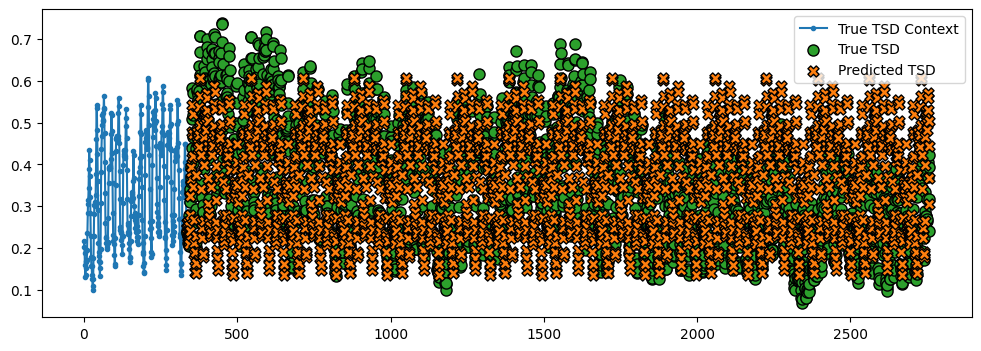

Day ConvLSTM prediction


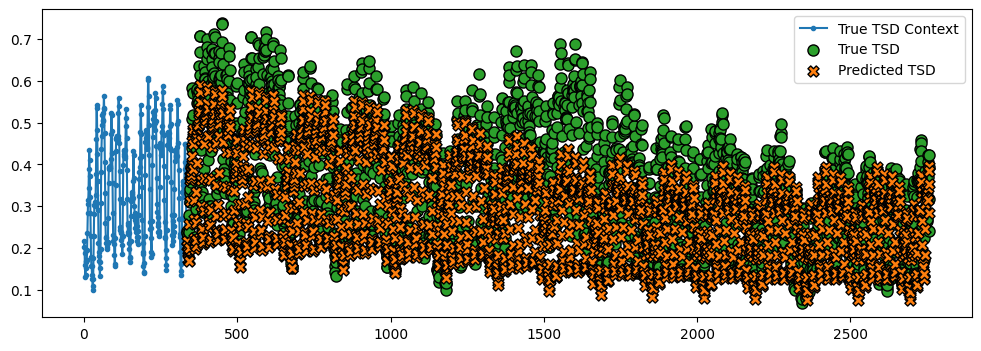

Hour ConvLSTM prediction


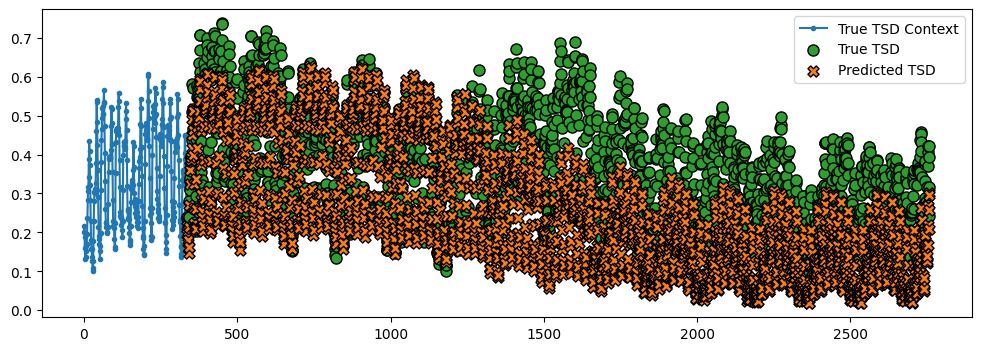

In [146]:
def get_metrics(y_true, y_predicted):
    mse = compute_error(y_predicted, y_true, "mse")
    mae = compute_error(y_predicted, y_true, "mae")
    rmse = compute_error(y_predicted, y_true, "rmse")
    return {"mse":mse, "mae":mae, "rmse":rmse}

def plot_variables(y_warm, y_true, y_predicted):
    plt.figure(figsize=(12, 4))
    
    X_warm = [i for i, _ in enumerate(y_warm)]
    X_predict = [i + len(X_warm) for i, _ in enumerate(y_true)]
    
    plt.plot(X_warm, y_warm, label='True TSD Context', marker='.', zorder=-10)
    plt.scatter(X_predict, y_true, label='True TSD', edgecolors='k', c='#2ca02c', s=64)
    plt.scatter(X_predict, y_predicted, label='Predicted TSD', marker='X', edgecolors='k', c='#ff7f0e', s=64)
    
    plt.legend()
    plt.show()
    
day_2023_metrics = get_metrics(test_2023_rest_tsd, day_2023_predictions)
week_2023_metrics = get_metrics(test_2023_rest_tsd, week_2023_predictions)
conv_lstm_2023_metrics = get_metrics(test_2023_rest_tsd, conv_lstm_2023_predictions)

conv_lstm_2023_hour_metrics = get_metrics(test_2023_rest_tsd, conv_lstm_2023_hour_predictions)

print("Day prediction", day_2023_metrics)
print("Week prediction", week_2023_metrics)
print("Day ConvLSTM prediction", conv_lstm_2023_metrics)

print("Hour ConvLSTM prediction", conv_lstm_2023_hour_metrics)


print("Day prediction")
plot_variables(test_2023_warmup_tsd, test_2023_rest_tsd, day_2023_predictions)
print("Week prediction")
plot_variables(test_2023_warmup_tsd, test_2023_rest_tsd, week_2023_predictions)
print("Day ConvLSTM prediction")
plot_variables(test_2023_warmup_tsd, test_2023_rest_tsd, conv_lstm_2023_predictions)
print("Hour ConvLSTM prediction")
plot_variables(test_2023_warmup_tsd, test_2023_rest_tsd, conv_lstm_2023_hour_predictions)

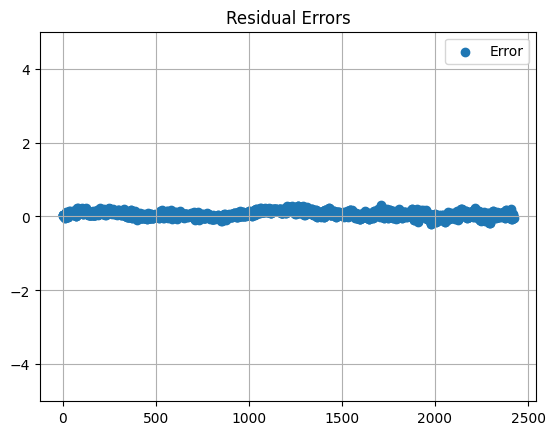

Mean 0.060212858
Standard deviation 0.07514879


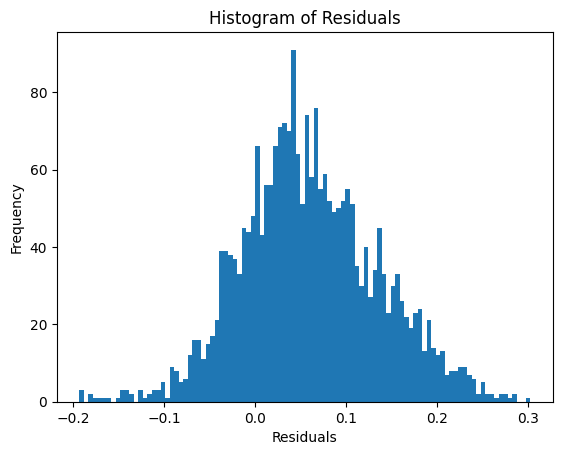

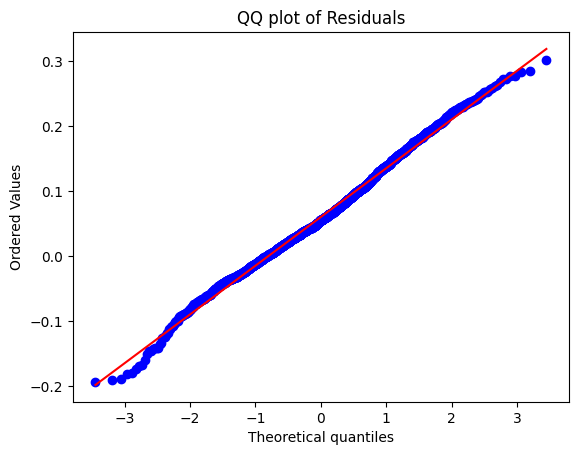

Shapiro-Wilk test p-value: 4.646076092740259e-07
The residuals are likely not normal
DAgostino K-squared test p-value: 0.007635901924455023
The residuals are likely not normal
Anderson-Darling test:
[0.575 0.655 0.786 0.916 1.09 ]
4.271639163317559
[15.  10.   5.   2.5  1. ]


In [119]:
residual_analysis(conv_lstm_2023_predictions, test_2023_rest_tsd)


### Prediciendo 2023 completo

Basado en las primeras dos semanas de 2023 se predice el año completo.

In [120]:
# Get whole year prediction
conv_lstm_whole_2023_predictions = get_autorregresive_predictions(conv_lstm_model, test_2023_warmup, days=350)


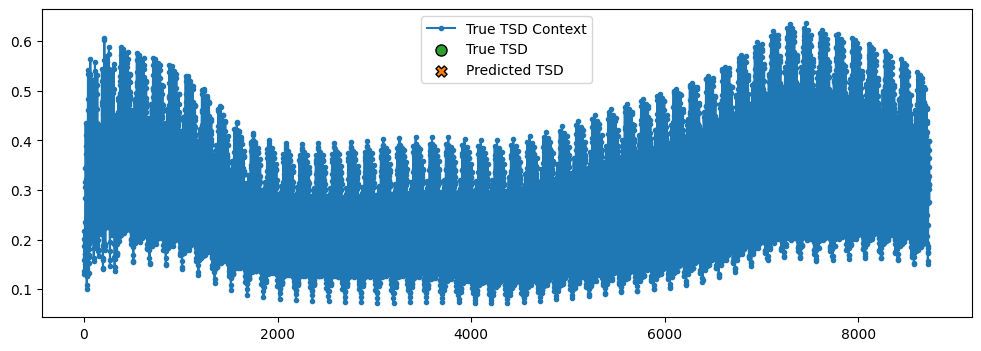

First 2 Weeks True Labels


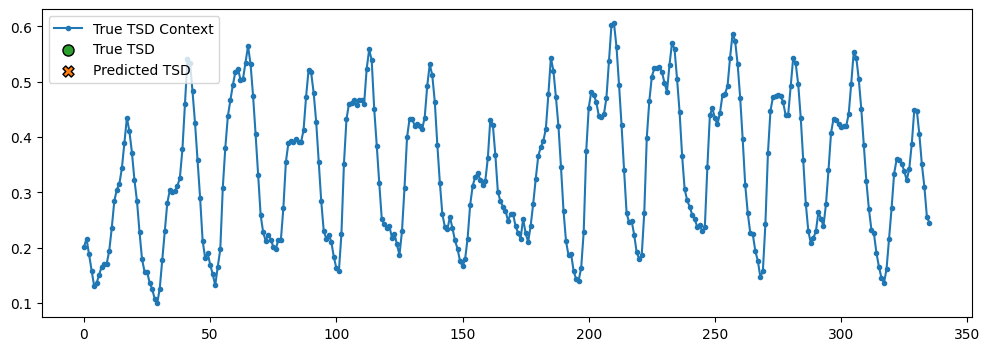

First 2 Predicted Weeks


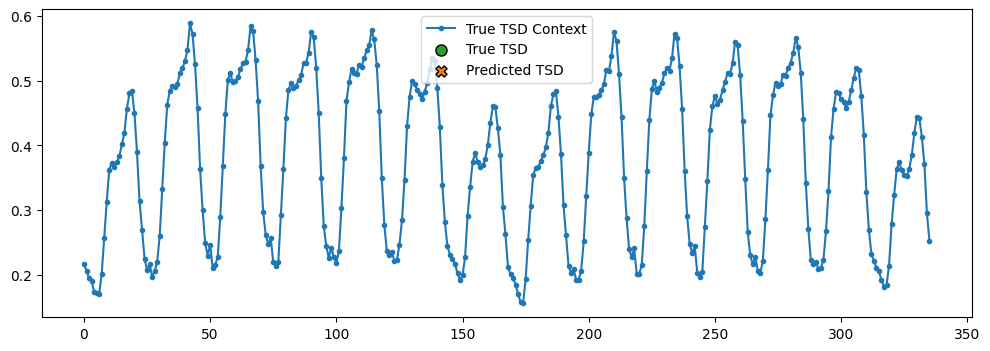

6th to 8th Predicted Weeks


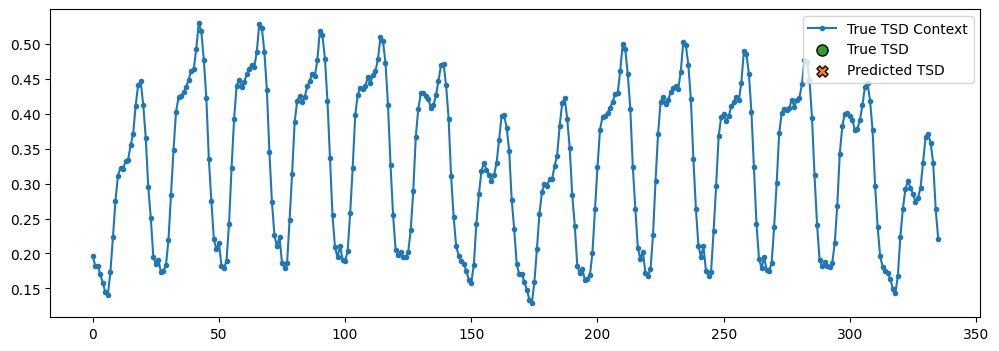

In [144]:
plot_variables(tf.concat([test_2023_warmup_tsd, conv_lstm_whole_2023_predictions], 0), [], [])
print("First 2 Weeks True Labels")
plot_variables(test_2023_warmup_tsd, [], [])
print("First 2 Predicted Weeks")
plot_variables(conv_lstm_whole_2023_predictions[:ONE_SHOT_CONTEXT_WINDOW], [], [])
print("6th to 8th Predicted Weeks")
plot_variables(conv_lstm_whole_2023_predictions[2*ONE_SHOT_CONTEXT_WINDOW:3*ONE_SHOT_CONTEXT_WINDOW], [], [])


### Resumen

- El modelo ConvLSTM es el que mejor se desempeña.
- La predicción obtiene mejores resultados al hacerla día a día.
- El modelo aprende las oscilaciones diarias, semanales y anuales de forma general.